#### **Libraries**

In [1]:
import warnings
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,coint
from sklearn.preprocessing import Normalizer,StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from numpy.core.fromnumeric import squeeze
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from scipy.stats import pearsonr
from matplotlib.pyplot import figure
warnings.filterwarnings("ignore")
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

#### Mount to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Fall 2022/Time Series Data Mining/Project"

Mounted at /content/drive
/content/drive/MyDrive/Fall 2022/Time Series Data Mining/Project


#### Data

In [3]:
df_covid = pd.read_csv('covid.csv')
df_vaccination = pd.read_csv('us_state_vaccinations.csv')

### Preprocessing

In [4]:
vaccine2 = df_vaccination.copy()

us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Washington DC', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
vaccine2 = vaccine2.loc[vaccine2['location'].isin(us_states)]
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}
inv_map = {v: k for k, v in states.items()}
vaccine2['state_abbrev'] = vaccine2['location'].map(inv_map)
vaccine2.head()

vaccine3 = df_vaccination.copy()
inv_map = {v: k for k, v in states.items()}
vaccine3['state_abbrev'] = vaccine3['location'].map(inv_map)
df_vaccination = vaccine3

In [5]:
def fetch_state_with_date(df_covid, df_vaccination,state ):

  df_covid['submission_date'] = pd.to_datetime(df_covid['submission_date'])
  df_covid = df_covid[(df_covid['state'] == state) & (df_covid['submission_date'] >= '2021-01-12')]
  df_covid = df_covid[['submission_date','new_case','new_death']]
  df_covid = df_covid.rename(columns={'submission_date' : 'date'})

  df_vaccination['date'] = pd.to_datetime(df_vaccination['date'])
  df_vaccination = df_vaccination[df_vaccination['state_abbrev']==state]

  df_vaccination = df_vaccination[['date','daily_vaccinations']]

  covid_vaccination_merged_df = df_covid.merge(df_vaccination, on='date')
  covid_vaccination_merged_df = covid_vaccination_merged_df.sort_values(by='date', ascending=True)
  covid_vaccination_merged_df = covid_vaccination_merged_df.dropna()
  
  return covid_vaccination_merged_df

In [6]:
df_covid_UT = fetch_state_with_date(df_covid, df_vaccination, 'UT')
df_covid_CA = fetch_state_with_date(df_covid, df_vaccination, 'CA')

# Utah

## Decomposition & Time Series Analysis

#### New Case

Utah New Case Stationary



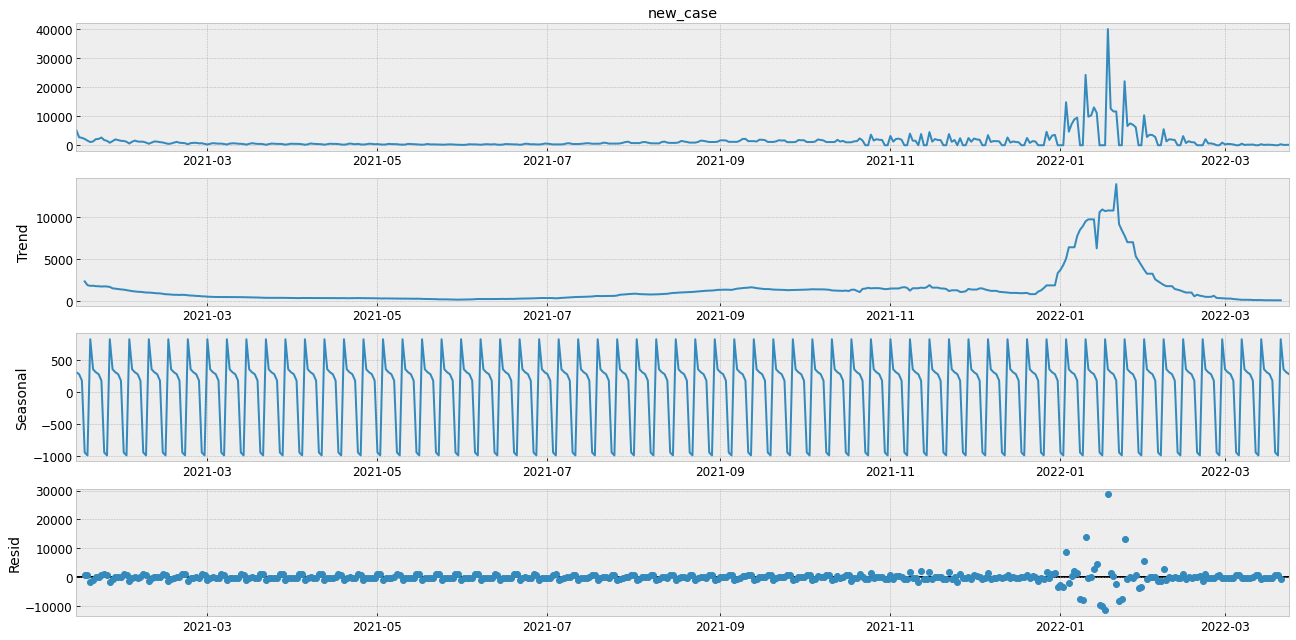

In [7]:
rcParams['figure.figsize'] = 18, 9

seriesUT = df_covid_UT.new_case
seriesUT.index = df_covid_UT.date
print('Utah New Case Stationary\n')

result = seasonal_decompose(seriesUT, model='additive')
result.plot()
plt.show()

In [8]:
def tsplot(y, lags, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "Data is stationary" if p_value <= 0.05 else "Data is Non-stationary"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = y.rolling(window=12).mean()
        rolstd = y.rolling(window=12).std()

        orig = plt.plot(y, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')

Utah New Case Stationary



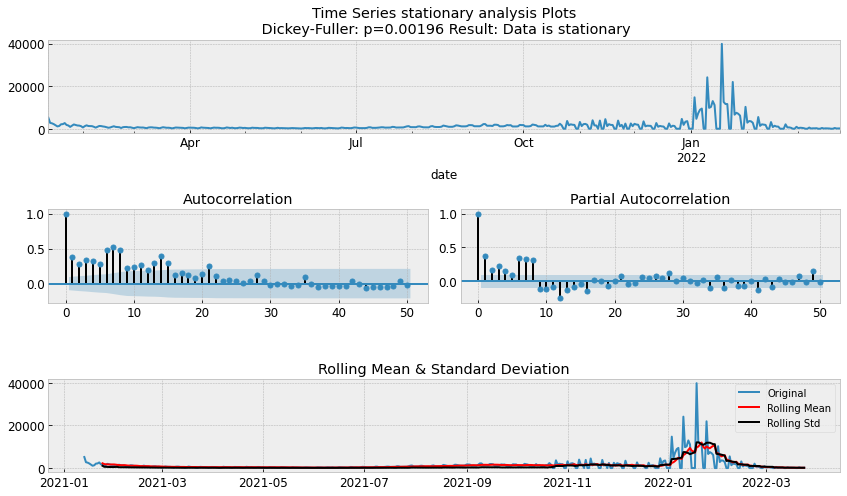

In [9]:
print('Utah New Case Stationary\n')
tsplot(seriesUT, lags=50)

#### New Death

Utah New death



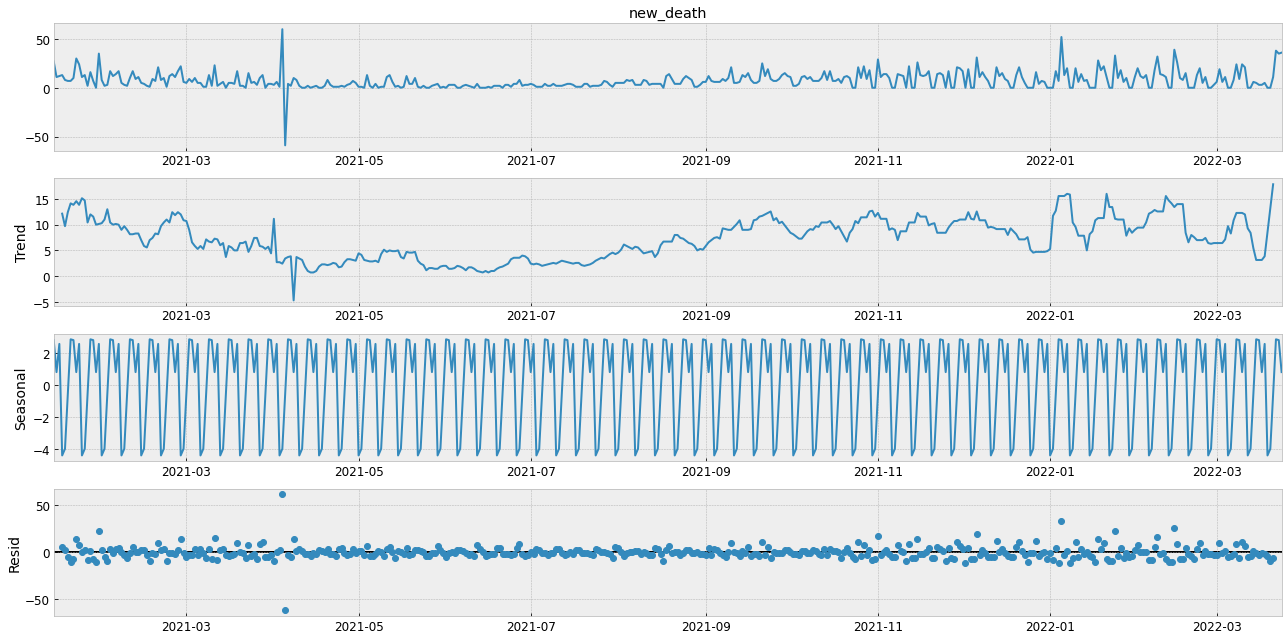

In [10]:
rcParams['figure.figsize'] = 18, 9

deathUT = df_covid_UT.new_death
deathUT.index = df_covid_UT.date
print('Utah New death\n')

result = seasonal_decompose(deathUT, model='additive')
result.plot()
plt.show()

Utah New death



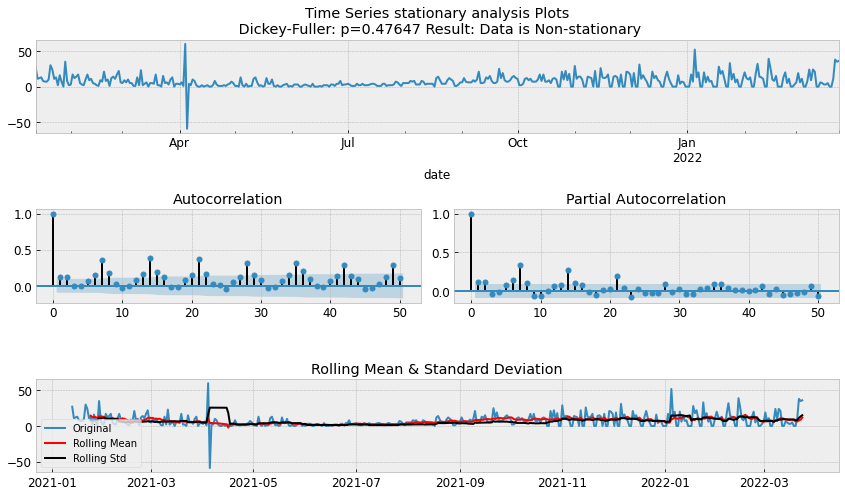

In [11]:
print('Utah New death\n')
tsplot(deathUT, lags=50)

In [12]:
diffUT = deathUT.shift(1).dropna()
diffUT = diffUT.diff().dropna()

Utah New Death Stationary



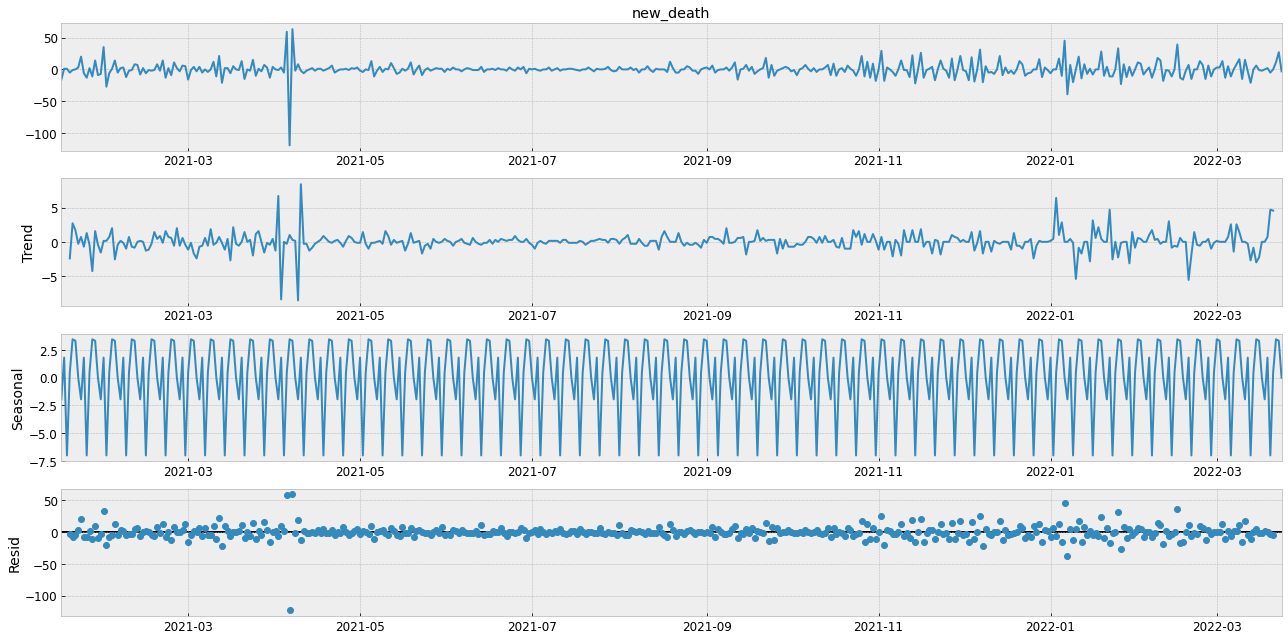

In [13]:
rcParams['figure.figsize'] = 18, 9

print('Utah New Death Stationary\n')

result = seasonal_decompose(diffUT, model='additive')
result.plot()
plt.show()

Utah New Death Stationary



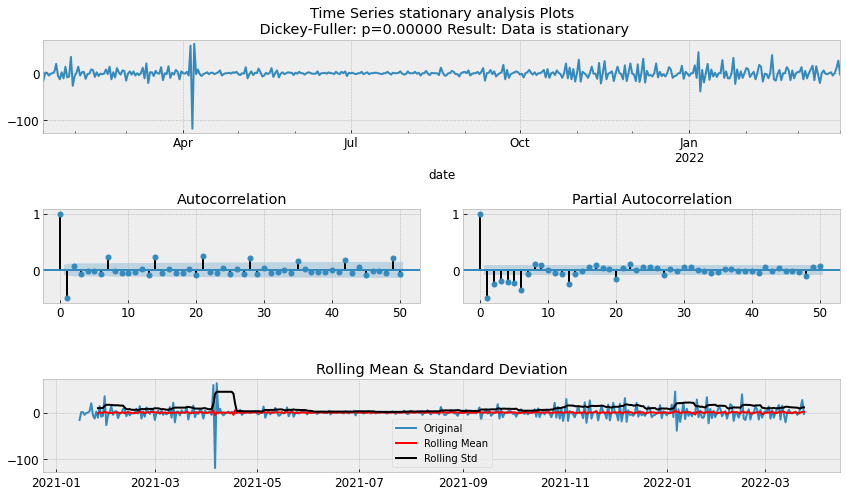

In [14]:
print('Utah New Death Stationary\n')
tsplot(diffUT, lags=50)

#### Vaccination

In [15]:
vaccination_UT = df_covid_UT.daily_vaccinations
vaccination_UT.index = df_covid_UT.date

Utah Vaccination



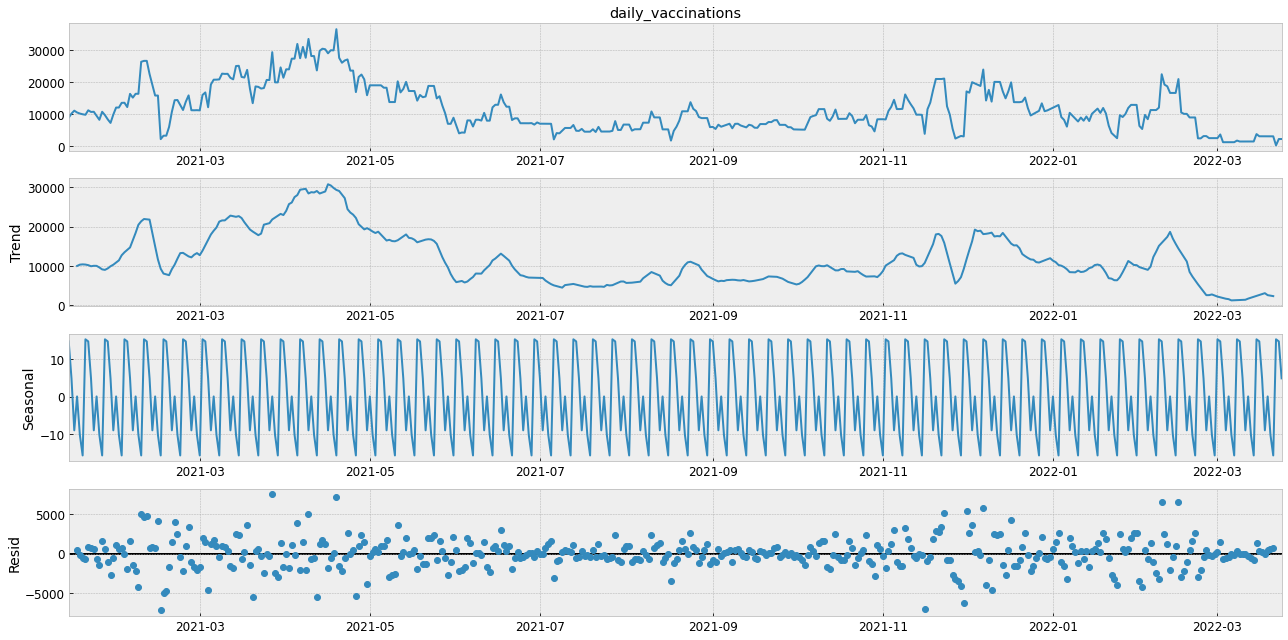

In [16]:
rcParams['figure.figsize'] = 18, 9
print('Utah Vaccination\n')

result = seasonal_decompose(vaccination_UT, model='additive')
result.plot()
plt.show()

Utah Vaccination



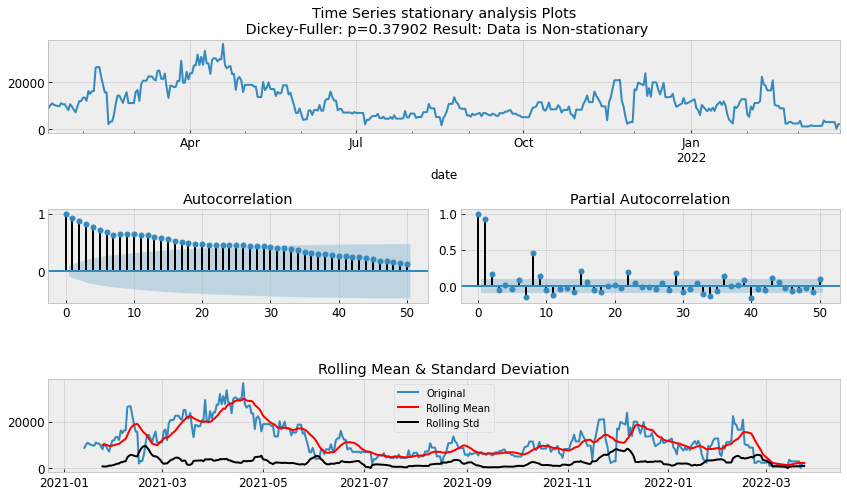

In [17]:
print('Utah Vaccination\n')
tsplot(vaccination_UT, lags=50)

In [18]:
diffUT = vaccination_UT.shift(1).dropna()
diffUT = diffUT.diff().dropna()

Utah Vaccination Stationary



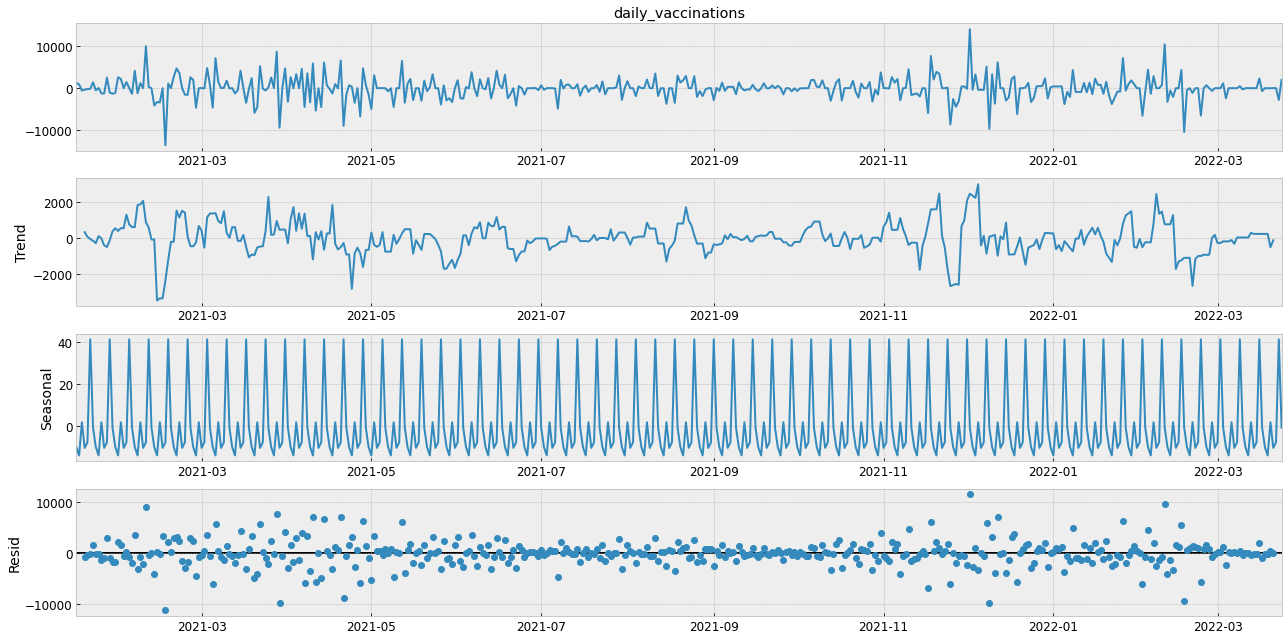

In [19]:
rcParams['figure.figsize'] = 18, 9
print('Utah Vaccination Stationary\n')

result = seasonal_decompose(diffUT, model='additive')
result.plot()
plt.show()

Utah Vaccination Stationary



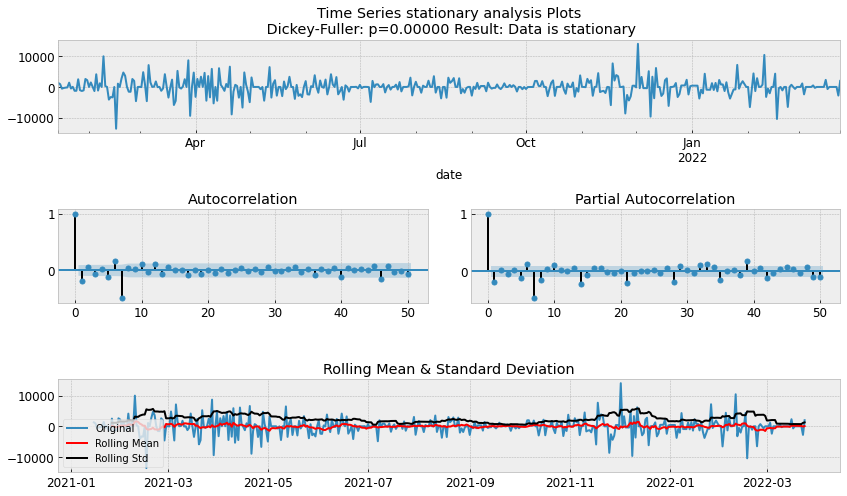

In [20]:
print('Utah Vaccination Stationary\n')
tsplot(diffUT, lags=50)

## Prediction of New Case

In [21]:
diffUT = seriesUT.shift(1).dropna()
diffUT = diffUT.diff().dropna()

In [22]:
train_set_UT = diffUT[diffUT.index < '2021-09-15']
test_set_UT = diffUT[diffUT.index > '2021-09-15']

In [23]:
scaler = StandardScaler()

In [24]:
X, y = [], []
time_steps = 45
for i in range(len(train_set_UT) - time_steps):
  x = train_set_UT[i:(i + time_steps)]
  X.append(x)
  y.append(train_set_UT[i + time_steps])

X = scaler.fit_transform(np.array(X))
y = scaler.fit_transform(np.array(y).reshape(-1,1)).reshape(-1,1)

split = int(len(X) * 0.8)
X_train_UT = X[:split]
X_test_UT = X[split:]
y_train_UT = y[:split]
y_test_UT = y[split:]
X_train_UT = np.reshape(X_train_UT, (X_train_UT.shape[0], 1, X_train_UT.shape[1]))
X_test_UT = np.reshape(X_test_UT, (X_test_UT.shape[0], 1, X_test_UT.shape[1]))

### Random Forest

In [25]:
regressor = RandomForestRegressor(n_estimators=100, min_samples_split=7)

In [26]:
regressor.fit(np.squeeze(X_train_UT, axis = 1),y_train_UT)

RandomForestRegressor(min_samples_split=7)

In [27]:
y_pred_UT = regressor.predict(np.squeeze(X_test_UT, axis = 1))
mseUTrf = mean_absolute_error(y_test_UT, y_pred_UT)
print('MAE:', mseUTrf)

MAE: 0.7915934249536222


In [28]:
rmseUTrf = np.sqrt(mean_squared_error(y_test_UT, y_pred_UT))
print('RMSE:', rmseUTrf)

RMSE: 1.2021268594133314


In [29]:
r2UTrf = r2_score(y_test_UT, y_pred_UT)
print('r2:', r2UTrf)

r2: 0.4158813391399835


Utah New Case Random Forest



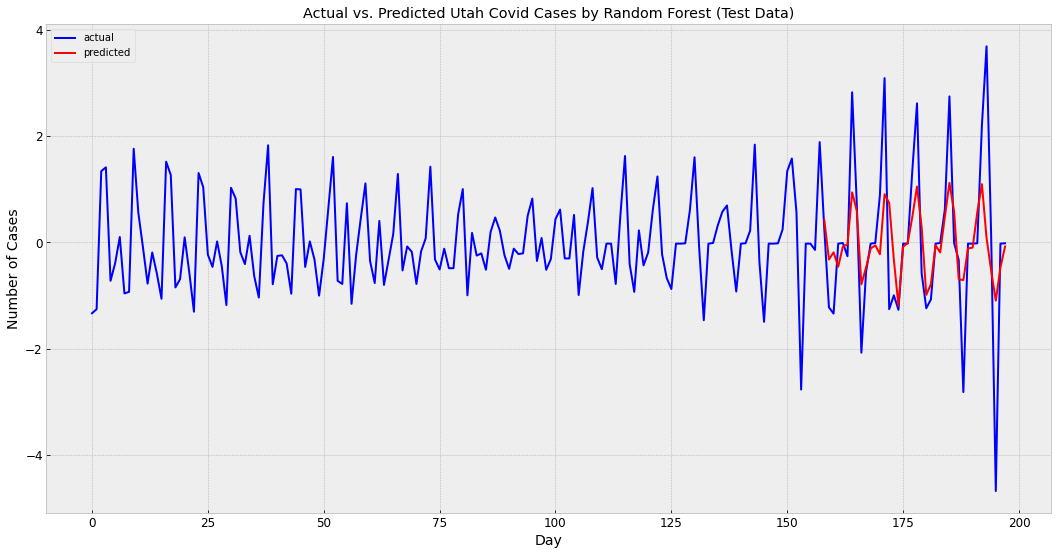

In [30]:
aUT = np.concatenate((y_train_UT, y_test_UT))
print('Utah New Case Random Forest\n')
plt.plot(aUT, color='blue', label='actual')
plt.plot(range(y_train_UT.shape[0], y_train_UT.shape[0] + y_pred_UT.shape[0]), y_pred_UT, color='red', label='predicted')
plt.title('Actual vs. Predicted Utah Covid Cases by Random Forest (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### XGBoost

In [31]:
model = XGBRegressor(n_estimators=20)
model.fit(np.squeeze(X_train_UT, axis=1),y_train_UT)

y_pred_UT = model.predict(np.squeeze(X_test_UT, axis = 1))
mseUTxg = mean_absolute_error(y_test_UT, y_pred_UT)
print('MAE:',mseUTxg)
rmseUTxg = mean_squared_error(y_test_UT, y_pred_UT)**.5
print('RMSE:',rmseUTxg)
r2UTxg = r2_score(y_test_UT, y_pred_UT)
print('r2:',r2UTxg)

[03:26:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.8294751233347
RMSE: 1.2650331607755398
r2: 0.35314893246270385


Utah New Case XGBoost



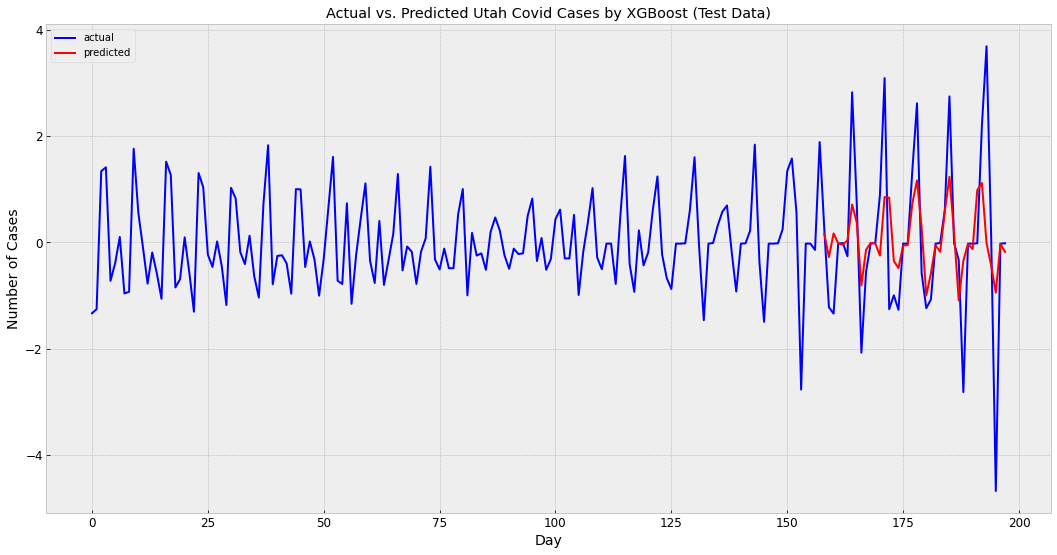

In [32]:
aUT = np.concatenate((y_train_UT, y_test_UT))
print('Utah New Case XGBoost\n')
plt.plot(aUT, color='blue', label='actual')
plt.plot(range(y_train_UT.shape[0], y_train_UT.shape[0] + y_pred_UT.shape[0]), y_pred_UT, color='red', label='predicted')
plt.title('Actual vs. Predicted Utah Covid Cases by XGBoost (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### LSTM

In [33]:
model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(90, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(90))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mean_squared_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 90)             48960     
                                                                 
 dropout (Dropout)           (None, 1, 90)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 48)             26688     
                                                                 
 dropout_1 (Dropout)         (None, 1, 48)             0         
                                                                 
 lstm_2 (LSTM)               (None, 90)                50040     
                                                                 
 dropout_2 (Dropout)         (None, 90)                0         
                                                                 
 dense (Dense)               (None, 1)                 9

In [34]:
batchsize = 32
epochs =  100
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)
history = model.fit(X_train_UT,
                    y_train_UT,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

Epoch 1/100
4/4 [==============================] - 7s 438ms/step - loss: 0.5571 - mean_squared_error: 0.5571 - val_loss: 0.8918 - val_mean_squared_error: 0.8918 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.5454 - mean_squared_error: 0.5454 - val_loss: 0.8875 - val_mean_squared_error: 0.8875 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.5307 - mean_squared_error: 0.5307 - val_loss: 0.8788 - val_mean_squared_error: 0.8788 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.5071 - mean_squared_error: 0.5071 - val_loss: 0.8632 - val_mean_squared_error: 0.8632 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 0.4723 - mean_squared_error: 0.4723 - val_loss: 0.8382 - val_mean_squared_error: 0.8382 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.4197 - mean_squared_error: 0.4197 - val_loss: 0.8012 - val_m

2/2 [==============================] - 1s 7ms/step
RMSE: 1.2766068190725794
MAE: 0.9489156746828703
r2: 0.34125884173339727
Utah New Case LSTM



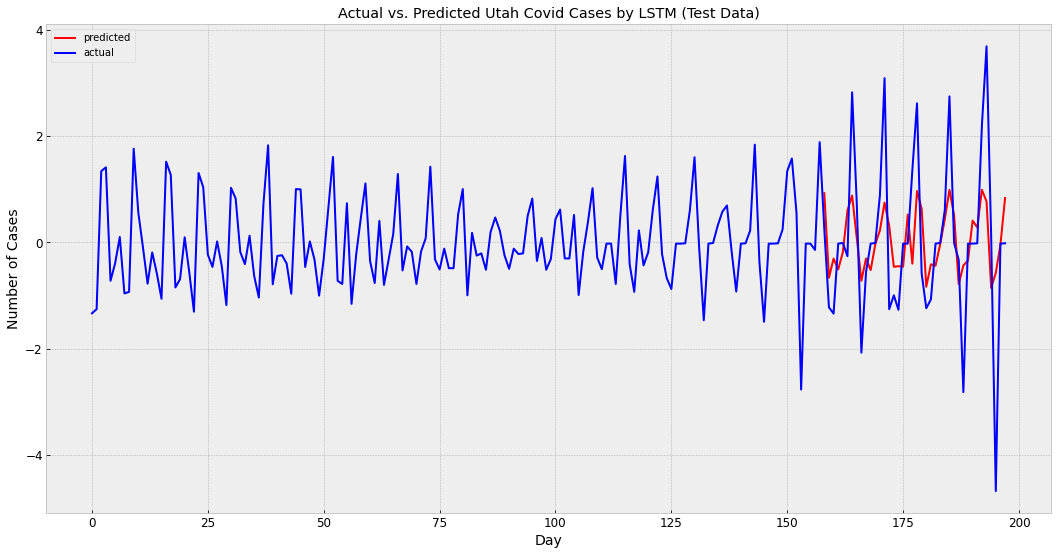

In [35]:
y_pred_UT = model.predict(X_test_UT)
rmseUTlstm = mean_squared_error(y_test_UT, y_pred_UT)**.5
print('RMSE:', rmseUTlstm)
mseUTlstm = mean_absolute_error(y_test_UT, y_pred_UT)
print('MAE:',mseUTlstm)
r2UTlstm = r2_score(y_test_UT, y_pred_UT)
print('r2:',r2UTlstm)

total_UT = np.concatenate((y_train_UT, y_test_UT))
t_UT = range(len(total_UT) - len(y_test_UT), len(total_UT))
print('Utah New Case LSTM\n')
plt.plot(t_UT, y_pred_UT, color='red')
plt.plot(total_UT, color='blue')
plt.title('Actual vs. Predicted Utah Covid Cases by LSTM (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])
plt.show()

## Prediction of New Death

In [36]:
diffUT = deathUT.shift(1).dropna()
diffUT = diffUT.diff().dropna()

In [37]:
train_set_UT = diffUT[diffUT.index < '2021-09-15']
test_set_UT = diffUT[diffUT.index > '2021-09-15']

In [38]:
scaler = StandardScaler()

In [39]:
X, y = [], []
time_steps = 45
for i in range(len(train_set_UT) - time_steps):
  x = train_set_UT[i:(i + time_steps)]
  X.append(x)
  y.append(train_set_UT[i + time_steps])

X = scaler.fit_transform(np.array(X))
y = scaler.fit_transform(np.array(y).reshape(-1,1)).reshape(-1,1)

split = int(len(X) * 0.8)
X_train_UT = X[:split]
X_test_UT = X[split:]
y_train_UT = y[:split]
y_test_UT = y[split:]
X_train_UT = np.reshape(X_train_UT, (X_train_UT.shape[0], 1, X_train_UT.shape[1]))
X_test_UT = np.reshape(X_test_UT, (X_test_UT.shape[0], 1, X_test_UT.shape[1]))

### Random Forest

In [40]:
regressor = RandomForestRegressor(n_estimators=100, min_samples_split=7)

In [41]:
regressor.fit(np.squeeze(X_train_UT, axis = 1),y_train_UT)

RandomForestRegressor(min_samples_split=7)

In [42]:
y_pred_UT = regressor.predict(np.squeeze(X_test_UT, axis = 1))
mseDUTrf = mean_absolute_error(y_test_UT, y_pred_UT)
print('MAE:', mseDUTrf)
rmseDUTrf = np.sqrt(mean_squared_error(y_test_UT, y_pred_UT))
print('RMSE:', rmseDUTrf)
r2DUTrf = r2_score(y_test_UT, y_pred_UT)
print('r2:', r2DUTrf)

MAE: 0.25799598919813427
RMSE: 0.3883099204643812
r2: 0.0553409412256487


Utah New Death Random Forest



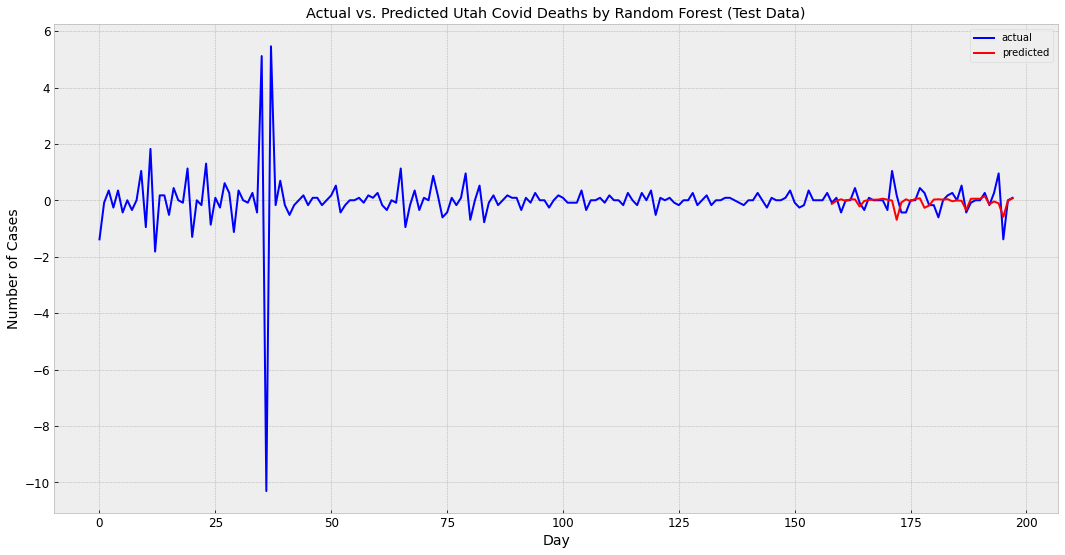

In [43]:
aUT = np.concatenate((y_train_UT, y_test_UT))
print('Utah New Death Random Forest\n')
plt.plot(aUT, color='blue', label='actual')
plt.plot(range(y_train_UT.shape[0], y_train_UT.shape[0] + y_pred_UT.shape[0]), y_pred_UT, color='red', label='predicted')
plt.title('Actual vs. Predicted Utah Covid Deaths by Random Forest (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### XGBoost

In [44]:
model = XGBRegressor(n_estimators=20)
model.fit(np.squeeze(X_train_UT, axis=1),y_train_UT)

y_pred_UT = model.predict(np.squeeze(X_test_UT, axis = 1))
mseDUTxg = mean_absolute_error(y_test_UT, y_pred_UT)
print('MAE:',mseDUTxg)
rmseDUTxg = mean_squared_error(y_test_UT, y_pred_UT)**.5
print('RMSE:',rmseDUTxg)
r2DUTxg = r2_score(y_test_UT, y_pred_UT)
print('r2:',r2DUTxg)

[03:26:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.2729725958853103
RMSE: 0.39675372549409055
r2: 0.013811012544012957


Utah New Death XGBoost



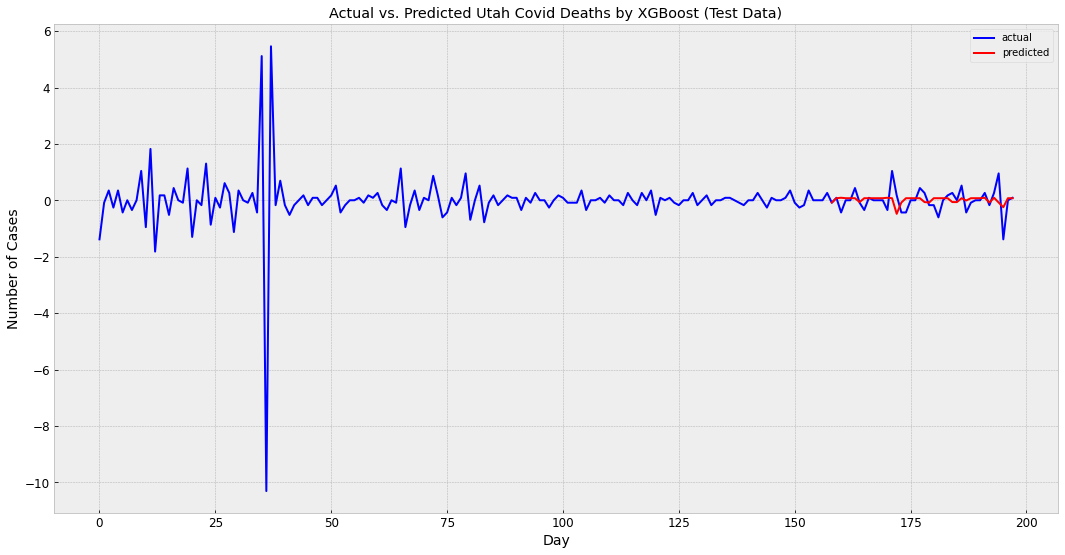

In [45]:
aUT = np.concatenate((y_train_UT, y_test_UT))
print('Utah New Death XGBoost\n')
plt.plot(aUT, color='blue', label='actual')
plt.plot(range(y_train_UT.shape[0], y_train_UT.shape[0] + y_pred_UT.shape[0]), y_pred_UT, color='red', label='predicted')
plt.title('Actual vs. Predicted Utah Covid Deaths by XGBoost (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### LSTM

In [46]:
model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(90, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(90))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mean_squared_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 90)             48960     
                                                                 
 dropout_3 (Dropout)         (None, 1, 90)             0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 48)             26688     
                                                                 
 dropout_4 (Dropout)         (None, 1, 48)             0         
                                                                 
 lstm_5 (LSTM)               (None, 90)                50040     
                                                                 
 dropout_5 (Dropout)         (None, 90)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [47]:
batchsize = 32
epochs =  100
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)
history = model.fit(X_train_UT,
                    y_train_UT,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

Epoch 1/100
4/4 [==============================] - 7s 412ms/step - loss: 1.5141 - mean_squared_error: 1.5141 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 1.5089 - mean_squared_error: 1.5089 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 1.5017 - mean_squared_error: 1.5017 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - lr: 0.0010
Epoch 4/100
1/4 [======>.......................] - ETA: 0s - loss: 0.5838 - mean_squared_error: 0.5838
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 15ms/step - loss: 1.4986 - mean_squared_error: 1.4986 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 1.4933 - mean_squared_error: 1.4933 - val_loss: 0.0250 - val_mean_sq

2/2 [==============================] - 1s 6ms/step
RMSE: 0.3986312409936397
MAE: 0.2595200425783048
r2: 0.0044552534425099655
Utah New Death LSTM



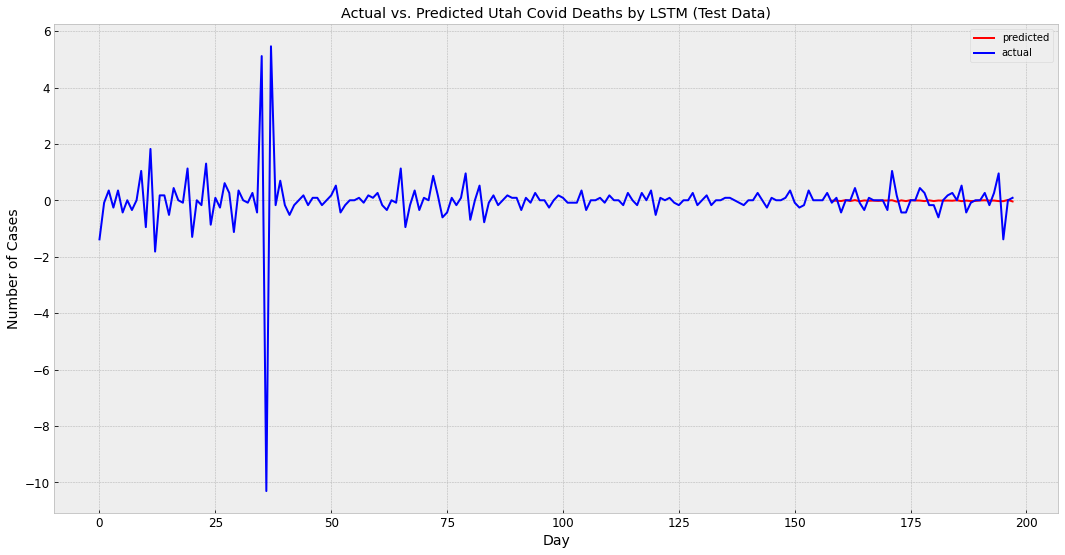

In [48]:
y_pred_UT = model.predict(X_test_UT)
rmseDUTlstm = mean_squared_error(y_test_UT, y_pred_UT)**.5
print('RMSE:', rmseDUTlstm)
mseDUTlstm = mean_absolute_error(y_test_UT, y_pred_UT)
print('MAE:',mseDUTlstm)
r2DUTlstm = r2_score(y_test_UT, y_pred_UT)
print('r2:',r2DUTlstm)

total_UT = np.concatenate((y_train_UT, y_test_UT))
t_UT = range(len(total_UT) - len(y_test_UT), len(total_UT))
print('Utah New Death LSTM\n')
plt.plot(t_UT, y_pred_UT, color='red')
plt.plot(total_UT, color='blue')
plt.title('Actual vs. Predicted Utah Covid Deaths by LSTM (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])
plt.show()

## Prediction of Vaccination Data

In [49]:
diffUT = vaccination_UT.shift(1).dropna()
diffUT = diffUT.diff().dropna()

In [50]:
train_set_UT_cv = diffUT[diffUT.index < '2021-09-15']

test_set_UT_cv = diffUT[diffUT.index > '2021-09-15']

X, y = [], []
time_steps = 45
for i in range(len(train_set_UT_cv) - time_steps):
  x = train_set_UT_cv[i:(i+time_steps)]
  X.append(x)
  y.append(train_set_UT_cv[i+time_steps])
X = scaler.fit_transform(np.array(X))
y = scaler.fit_transform(np.array(y).reshape(-1,1)).reshape(-1,1)

split = int(len(X) * 0.8)
X_train_UT_cv = X[:split]
X_test_UT_cv = X[split:]
y_train_UT_cv = y[:split]
y_test_UT_cv = y[split:]
X_train_UT_cv = np.reshape(X_train_UT_cv, (X_train_UT_cv.shape[0], 1, X_train_UT_cv.shape[1]))
X_test_UT_cv = np.reshape(X_test_UT_cv, (X_test_UT_cv.shape[0], 1, X_test_UT_cv.shape[1]))

### Random Forest

In [51]:
regressor = RandomForestRegressor(n_estimators=100, min_samples_split=7)

In [52]:
regressor.fit(np.squeeze(X_train_UT_cv, axis =1 ), y_train_UT_cv)

RandomForestRegressor(min_samples_split=7)

RMSE 0.5562973023006083
MAE 0.3803612461520921
r2 0.19312711221148404
Utah Vaccination Random Forest



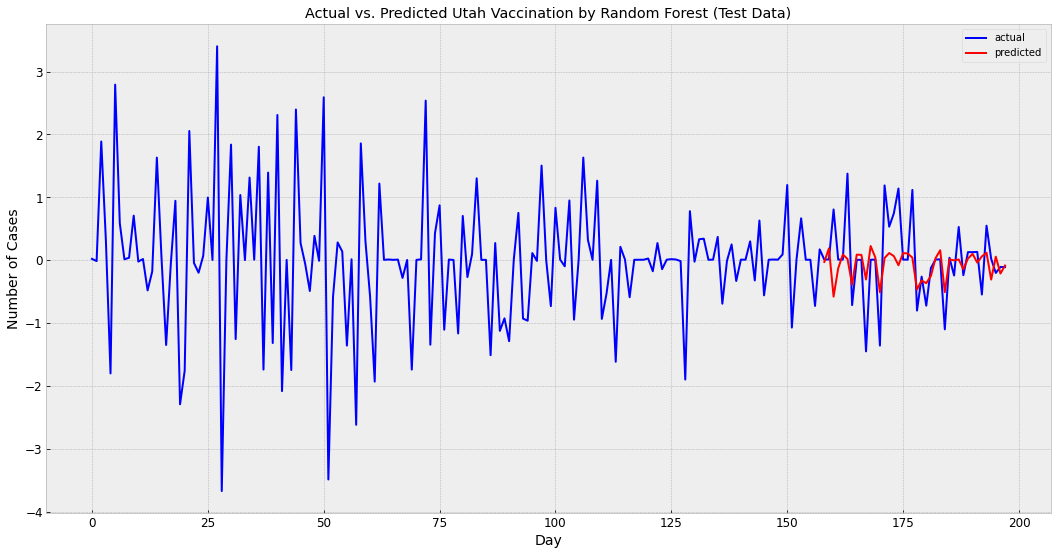

In [53]:
y_pred_UT_cv = regressor.predict(np.squeeze(X_test_UT_cv, axis =1 ))
rmseUTcvRF = mean_squared_error(y_test_UT_cv,y_pred_UT_cv)**.5
print('RMSE', rmseUTcvRF)
mseUTcvRF = mean_absolute_error(y_test_UT_cv,y_pred_UT_cv)
print('MAE', mseUTcvRF)
r2UTcvRF = r2_score(y_test_UT_cv,y_pred_UT_cv)
print('r2', r2UTcvRF)

a = np.concatenate((y_train_UT_cv,y_test_UT_cv))
print('Utah Vaccination Random Forest\n')
plt.plot(a, color='blue', label='actual')
plt.plot(range(y_train_UT_cv.shape[0], y_train_UT_cv.shape[0] + y_pred_UT_cv.shape[0]), y_pred_UT_cv, color='red', label='predicted')
plt.title('Actual vs. Predicted Utah Vaccination by Random Forest (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### XGBoost

In [54]:
model = XGBRegressor(n_estimators=20)
model.fit(np.squeeze(X_train_UT_cv),y_train_UT_cv)

y_pred_UT_cv = model.predict(np.squeeze(X_test_UT_cv))
rmseUTcvXG = mean_squared_error(y_test_UT_cv,y_pred_UT_cv)**.5
print('RMSE:',rmseUTcvXG)
mseUTcvXG = mean_absolute_error(y_test_UT_cv,y_pred_UT_cv)
print('MAE', mseUTcvXG)
r2UTcvXG = r2_score(y_test_UT_cv,y_pred_UT_cv)
print('r2', r2UTcvXG)

[03:26:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.5575124097184566
MAE 0.42058943876483584
r2 0.18959839474183626


Utah Vaccination XGBoost



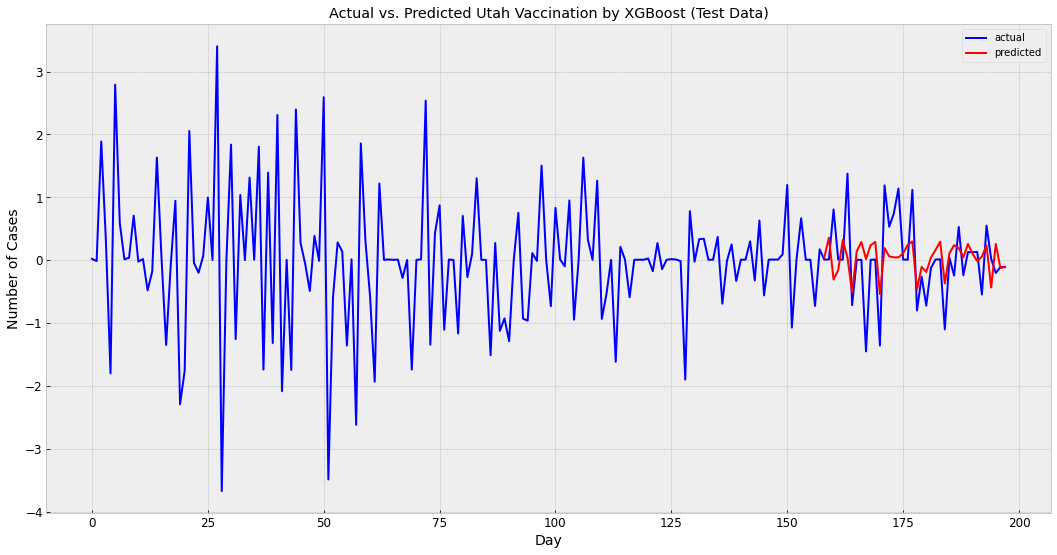

In [55]:
a = np.concatenate((y_train_UT_cv,y_test_UT_cv))
print('Utah Vaccination XGBoost\n')
plt.plot(np.squeeze(a,axis = 1), color='blue', label='actual')
plt.plot(range(y_train_UT_cv.shape[0], y_train_UT_cv.shape[0] + y_pred_UT_cv.shape[0]), y_pred_UT_cv, color='red', label='predicted')
plt.title('Actual vs. Predicted Utah Vaccination by XGBoost (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### LSTM

In [56]:
model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(180, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(90, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(90))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mean_squared_error'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 180)            162720    
                                                                 
 dropout_6 (Dropout)         (None, 1, 180)            0         
                                                                 
 lstm_7 (LSTM)               (None, 1, 90)             97560     
                                                                 
 dropout_7 (Dropout)         (None, 1, 90)             0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 60)             36240     
                                                                 
 dropout_8 (Dropout)         (None, 1, 60)             0         
                                                                 
 lstm_9 (LSTM)               (None, 1, 48)            

In [57]:
batchsize = 32
epochs =  100
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-2)
history = model.fit(X_train_UT_cv,
                    y_train_UT_cv,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

Epoch 1/100
4/4 [==============================] - 11s 672ms/step - loss: 1.3730 - mean_squared_error: 1.3730 - val_loss: 0.3033 - val_mean_squared_error: 0.3033 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 1.3725 - mean_squared_error: 1.3725 - val_loss: 0.3032 - val_mean_squared_error: 0.3032 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 19ms/step - loss: 1.3722 - mean_squared_error: 1.3722 - val_loss: 0.3032 - val_mean_squared_error: 0.3032 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 0s 21ms/step - loss: 1.3713 - mean_squared_error: 1.3713 - val_loss: 0.3031 - val_mean_squared_error: 0.3031 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 21ms/step - loss: 1.3702 - mean_squared_error: 1.3702 - val_loss: 0.3029 - val_mean_squared_error: 0.3029 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 0s 20ms/step - loss: 1.3666 - mean_squared_error: 1.3666 - val_loss: 0.3025 - val_

2/2 [==============================] - 2s 8ms/step
RMSE: 0.622573815156519
MAE 0.5107864041011013
r2 -0.010585159752803941
Utah Vaccination LSTM



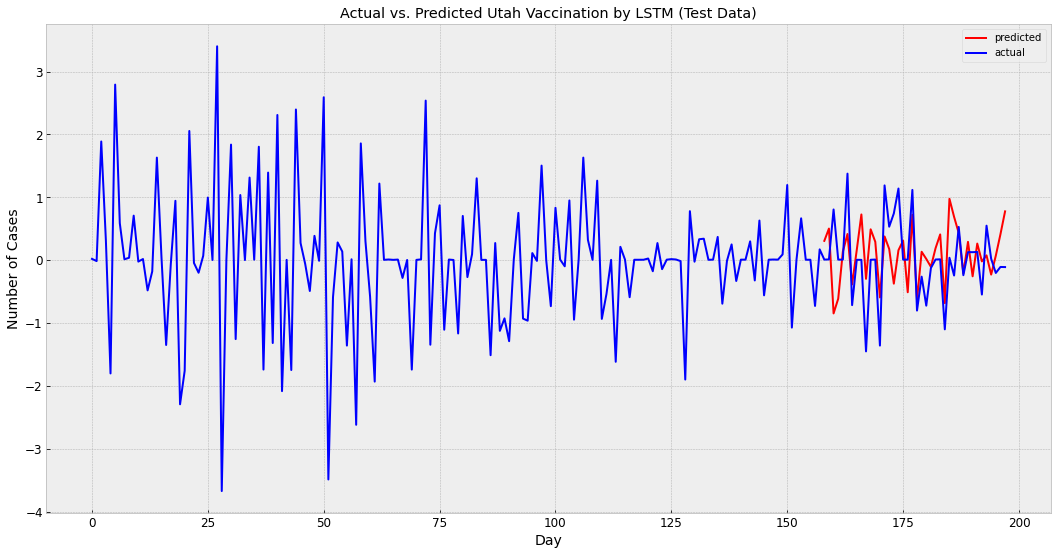

In [58]:
y_pred_UT_cv = model.predict(X_test_UT_cv)
rmseUTcvLSTM = mean_squared_error(y_test_UT_cv,y_pred_UT_cv)**.5
print('RMSE:', rmseUTcvLSTM)
mseUTcvLSTM = mean_absolute_error(y_test_UT_cv,y_pred_UT_cv)
print('MAE', mseUTcvLSTM)
r2UTcvLSTM = r2_score(y_test_UT_cv,y_pred_UT_cv)
print('r2', r2UTcvLSTM)

total_UT_cv = np.concatenate((y_train_UT_cv,y_test_UT_cv))
t_UT_cv = range(len(total_UT_cv) - len(y_test_UT_cv), len(total_UT_cv))
print('Utah Vaccination LSTM\n')
plt.plot(t_UT_cv, y_pred_UT_cv, color='red')
plt.plot(total_UT_cv, color='blue')
plt.title('Actual vs. Predicted Utah Vaccination by LSTM (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])
plt.show()

# California

## Decomposition & Time Series Analysis

#### New Case

California New Case Stationary



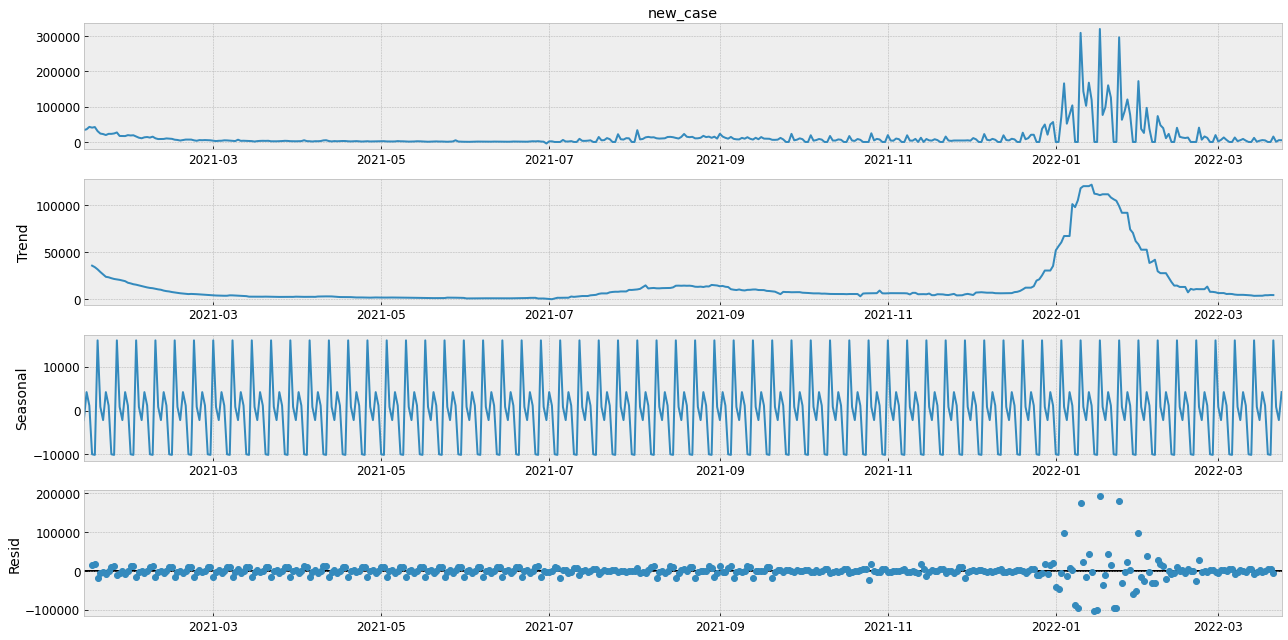

In [59]:
rcParams['figure.figsize'] = 18, 9

seriesCA = df_covid_CA.new_case
seriesCA.index = df_covid_CA.date
print('California New Case Stationary\n')

result = seasonal_decompose(seriesCA, model='additive')
result.plot()
plt.show()

California New Case Stationary



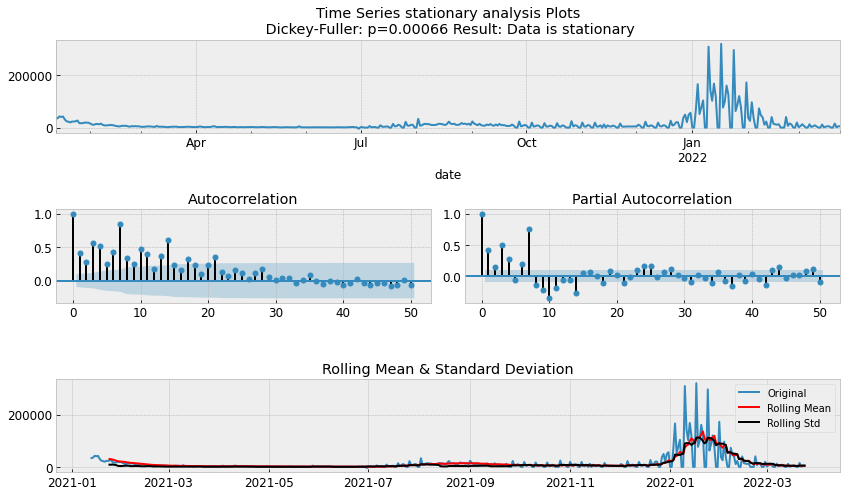

In [60]:
print('California New Case Stationary\n')
tsplot(seriesCA, lags=50)

#### New Death

California New Death



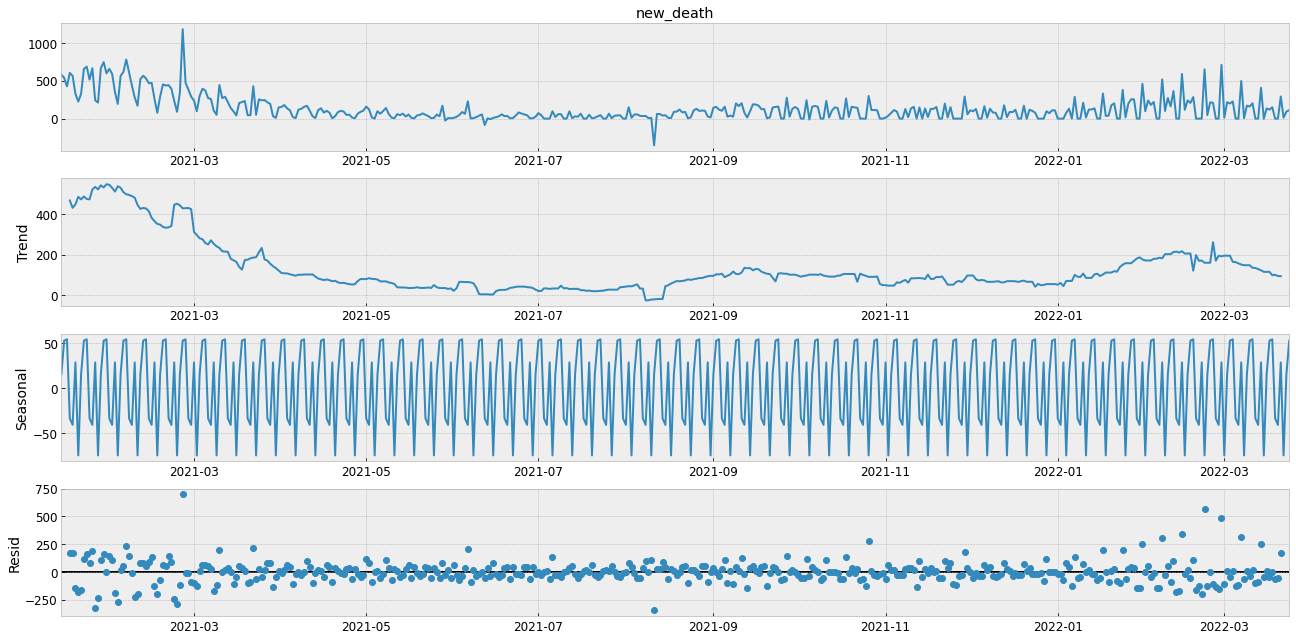

In [61]:
rcParams['figure.figsize'] = 18, 9

deathCA = df_covid_CA.new_death
deathCA.index = df_covid_CA.date
print('California New Death\n')

result = seasonal_decompose(deathCA, model='additive')
result.plot()
plt.show()

California New Death



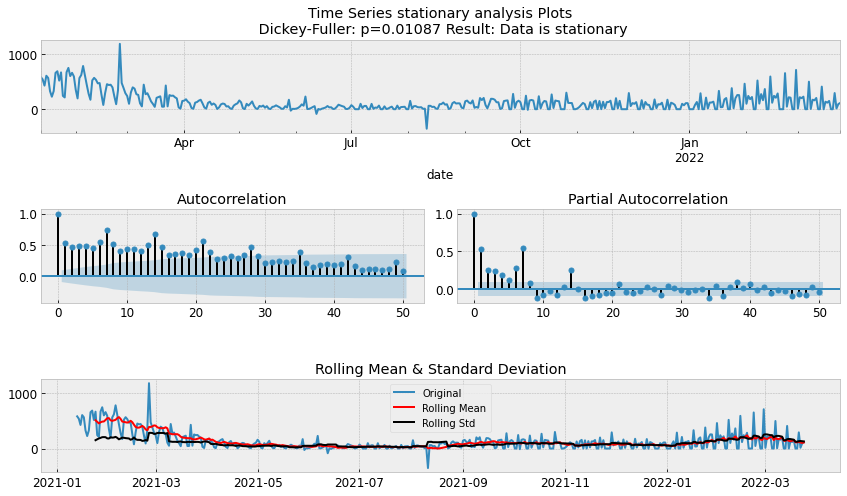

In [62]:
print('California New Death\n')
tsplot(deathCA, lags=50)

In [63]:
diffCA = deathCA.shift(1).dropna()
diffCA = diffCA.diff().dropna()

California New Death Stationary



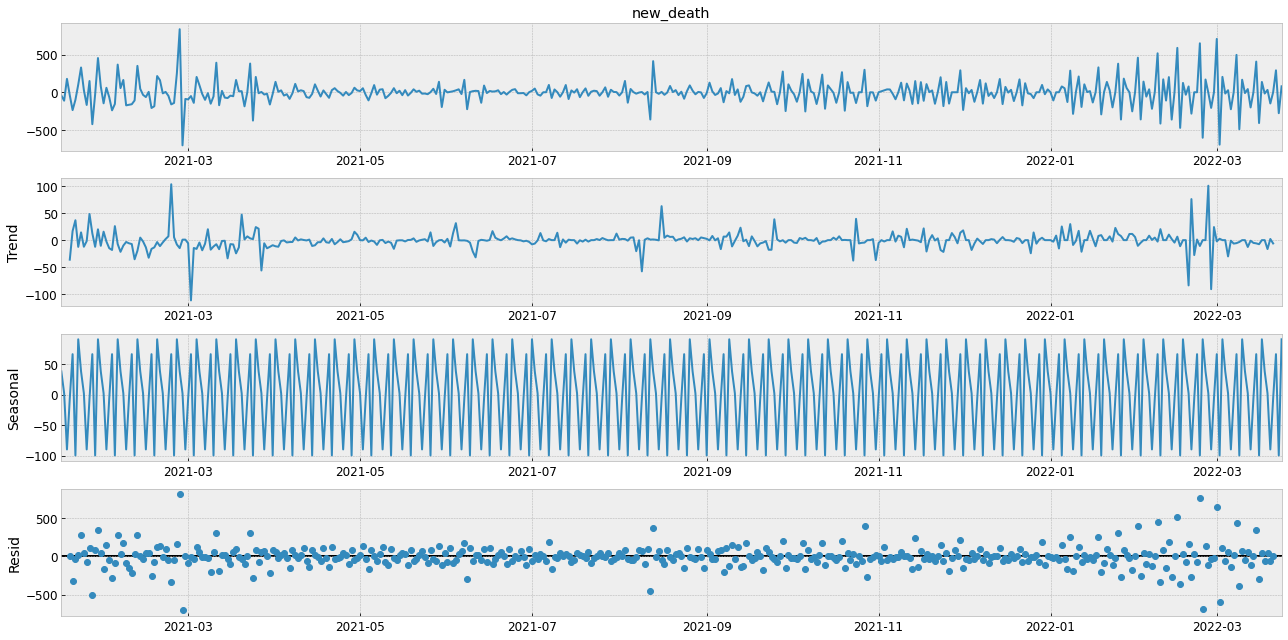

In [64]:
rcParams['figure.figsize'] = 18, 9
print('California New Death Stationary\n')

result = seasonal_decompose(diffCA, model='additive')
result.plot()
plt.show()

California New Death Stationary



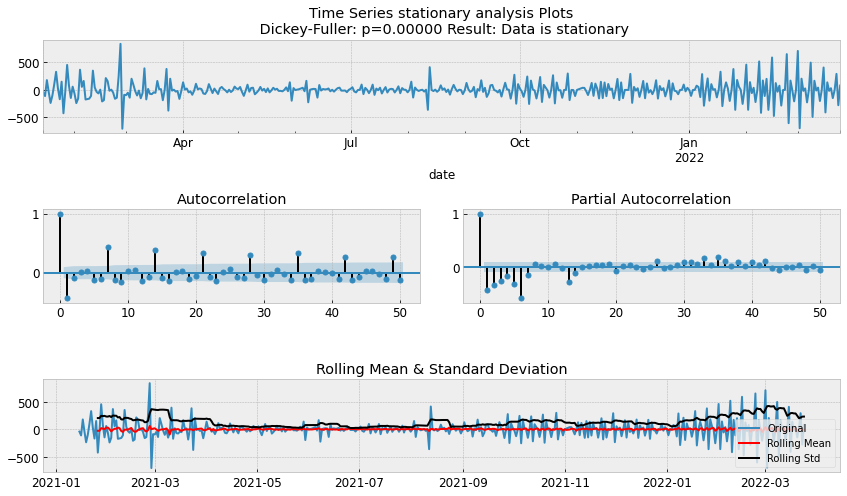

In [65]:
print('California New Death Stationary\n')
tsplot(diffCA, lags=50)

#### Vaccination

In [66]:
vaccination_CA = df_covid_CA.daily_vaccinations
vaccination_CA.index = df_covid_CA.date

California Vaccination



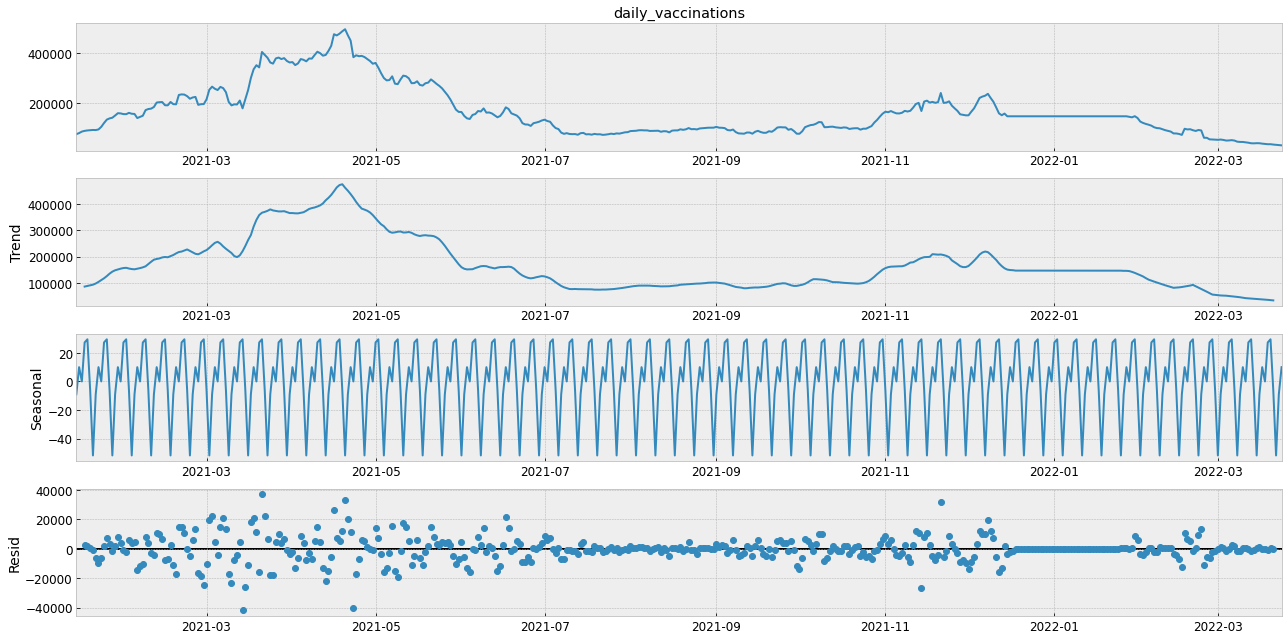

In [67]:
rcParams['figure.figsize'] = 18, 9
print('California Vaccination\n')

result = seasonal_decompose(vaccination_CA, model='additive')
result.plot()
plt.show()

California Vaccination



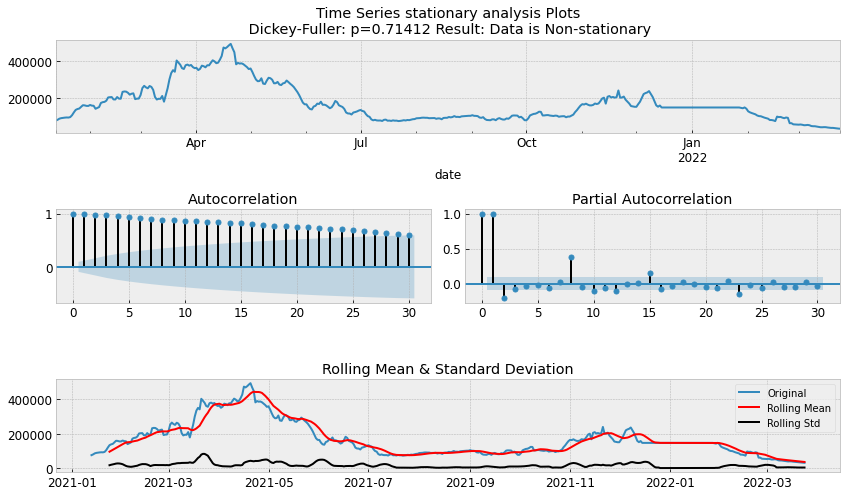

In [68]:
print('California Vaccination\n')
tsplot(vaccination_CA, lags=30)

In [69]:
diffCA = vaccination_CA.shift(1).dropna()
diffCA = diffCA.diff().dropna()

Utah Vaccination Stationary



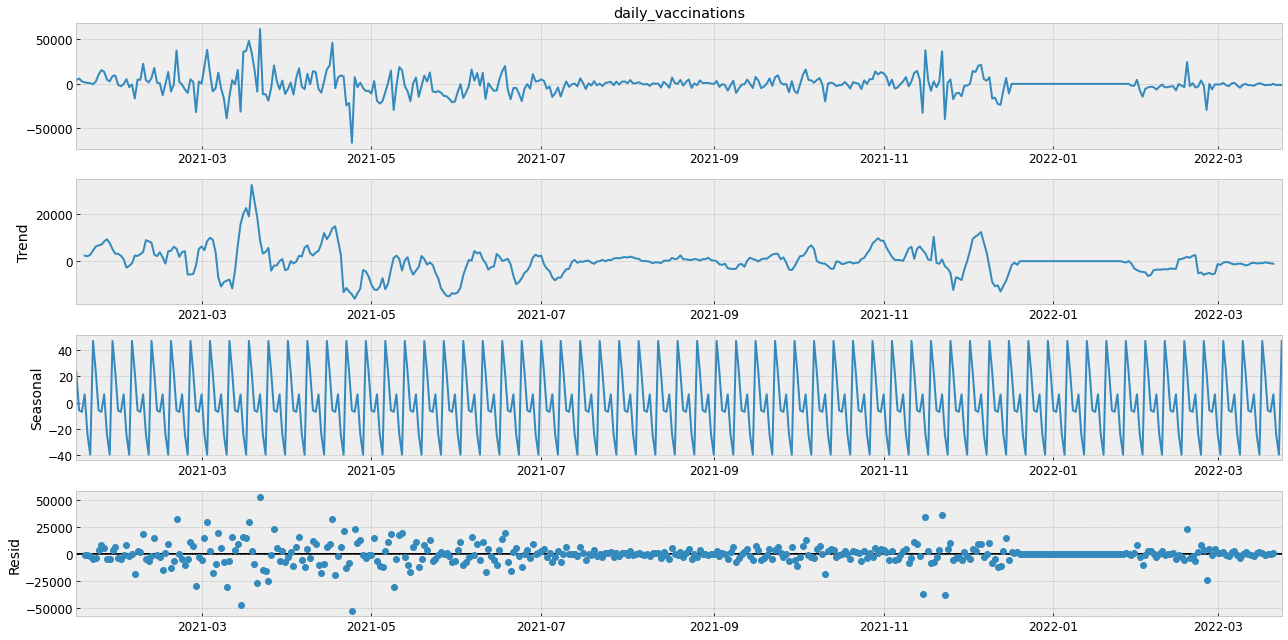

In [70]:
rcParams['figure.figsize'] = 18, 9
print('Utah Vaccination Stationary\n')

result = seasonal_decompose(diffCA, model='additive')
result.plot()
plt.show()

California Vaccination Stationary



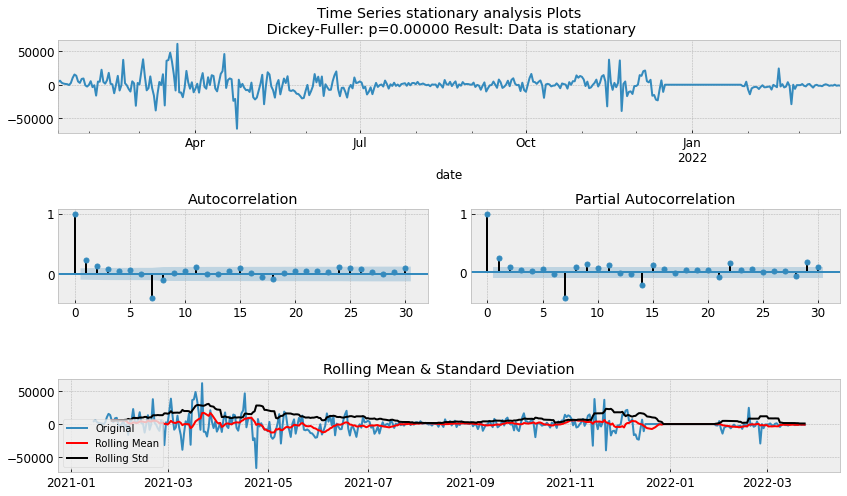

In [71]:
print('California Vaccination Stationary\n')
tsplot(diffCA, lags=30)

## Prediction of New Case

In [72]:
diffCA = seriesCA.shift(1).dropna()
diffCA = diffCA.diff().dropna()

In [73]:
train_set_CA = diffCA[diffCA.index < '2021-09-15']
test_set_CA = diffCA[diffCA.index > '2021-09-15']

In [74]:
scaler = StandardScaler()

In [75]:
X, y = [], []
time_steps = 45
for i in range(len(train_set_CA) - time_steps):
  x = train_set_CA[i:(i + time_steps)]
  X.append(x)
  y.append(train_set_CA[i + time_steps])

X = scaler.fit_transform(np.array(X))
y = scaler.fit_transform(np.array(y).reshape(-1,1)).reshape(-1,1)

split = int(len(X) * 0.8)
X_train_CA = X[:split]
X_test_CA = X[split:]
y_train_CA = y[:split]
y_test_CA = y[split:]
X_train_CA = np.reshape(X_train_UT, (X_train_CA.shape[0], 1, X_train_CA.shape[1]))
X_test_CA = np.reshape(X_test_CA, (X_test_CA.shape[0], 1, X_test_CA.shape[1]))

### Random Forest

In [76]:
regressor = RandomForestRegressor(n_estimators=100, min_samples_split=7)

In [77]:
regressor.fit(np.squeeze(X_train_CA, axis = 1),y_train_CA)

RandomForestRegressor(min_samples_split=7)

RMSE: 1.0412728872097705
MAE: 0.8227357410413528
r2: -0.23791155549096787
California New Case Random Forest



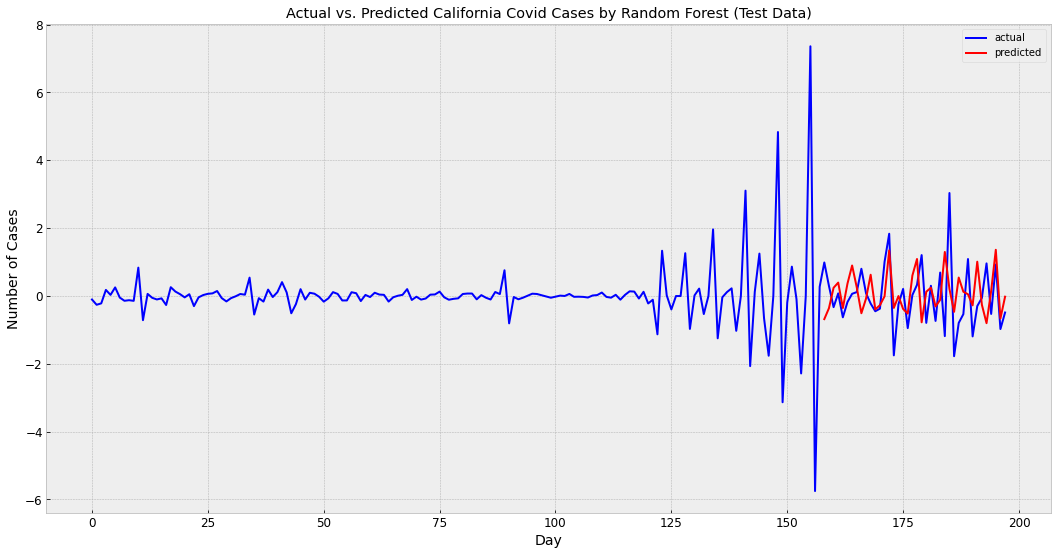

In [78]:
y_pred_CA = regressor.predict(np.squeeze(X_test_CA, axis = 1))
rmseCArf = mean_squared_error(y_test_CA, y_pred_CA)**.5
print('RMSE:', rmseCArf)
mseCArf = mean_absolute_error(y_test_CA, y_pred_CA)
print('MAE:', mseCArf)
r2CArf = r2_score(y_test_CA, y_pred_CA)
print('r2:', r2CArf)

aCA = np.concatenate((y_train_CA, y_test_CA))
print('California New Case Random Forest\n')
plt.plot(aCA, color='blue', label='actual')
plt.plot(range(y_train_CA.shape[0], y_train_CA.shape[0] + y_pred_CA.shape[0]), y_pred_CA, color='red', label='predicted')
plt.title('Actual vs. Predicted California Covid Cases by Random Forest (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### XGBoost

In [79]:
model = XGBRegressor(n_estimators=20)
model.fit(np.squeeze(X_train_CA, axis=1),y_train_CA)

y_pred_CA = model.predict(np.squeeze(X_test_CA, axis = 1))
rmseCAxg = mean_squared_error(y_test_CA, y_pred_CA)**.5
print('RMSE:',rmseCAxg)
mseCAxg = mean_absolute_error(y_test_CA, y_pred_CA)
print('MAE:', mseCAxg)
r2CAxg = r2_score(y_test_CA, y_pred_CA)
print('r2:', r2CAxg)

[03:27:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.0639780561989798
MAE: 0.8491643219348589
r2: -0.29248597256096454


California New Case XGBoost



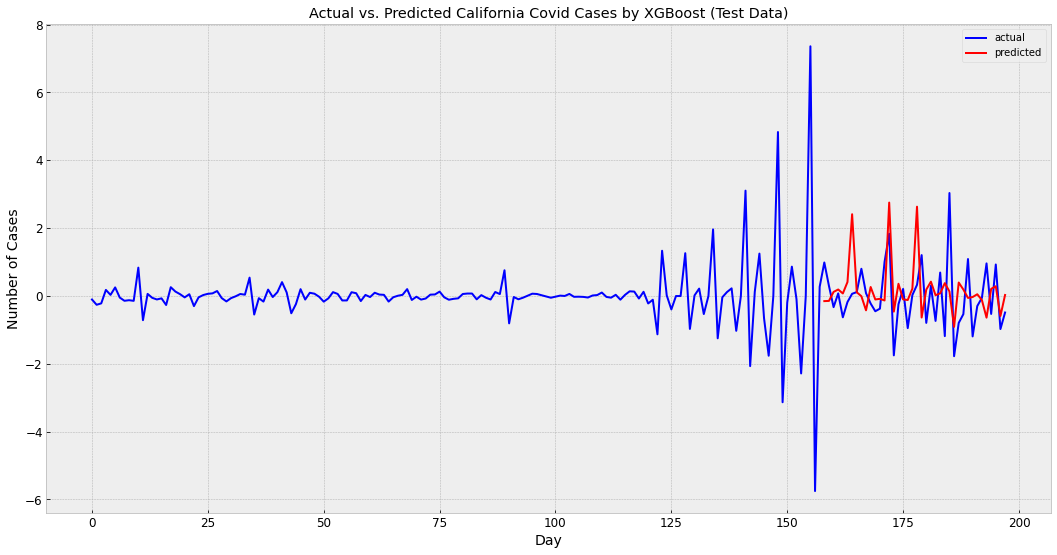

In [80]:
aCA = np.concatenate((y_train_CA, y_test_CA))
print('California New Case XGBoost\n')
plt.plot(aCA, color='blue', label='actual')
plt.plot(range(y_train_CA.shape[0], y_train_CA.shape[0] + y_pred_CA.shape[0]), y_pred_CA, color='red', label='predicted')
plt.title('Actual vs. Predicted California Covid Cases by XGBoost (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### LSTM

In [81]:
model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(90, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(90))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mean_squared_error'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1, 90)             48960     
                                                                 
 dropout_11 (Dropout)        (None, 1, 90)             0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 48)             26688     
                                                                 
 dropout_12 (Dropout)        (None, 1, 48)             0         
                                                                 
 lstm_13 (LSTM)              (None, 90)                50040     
                                                                 
 dropout_13 (Dropout)        (None, 90)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [82]:
batchsize = 32
epochs =  100
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)
history = model.fit(X_train_CA,
                    y_train_CA,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

Epoch 1/100
4/4 [==============================] - 8s 418ms/step - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 4.8421 - val_mean_squared_error: 4.8421 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0631 - mean_squared_error: 0.0631 - val_loss: 4.8428 - val_mean_squared_error: 4.8428 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0624 - mean_squared_error: 0.0624 - val_loss: 4.8431 - val_mean_squared_error: 4.8431 - lr: 0.0010
Epoch 4/100
1/4 [======>.......................] - ETA: 0s - loss: 0.0553 - mean_squared_error: 0.0553
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 17ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - val_loss: 4.8431 - val_mean_squared_error: 4.8431 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0616 - mean_squared_error: 0.0616 - val_loss: 4.8430 - val_mean_sq

2/2 [==============================] - 1s 6ms/step
RMSE: 0.927142422372166
MAE: 0.7030949877637959
r2: 0.018583393100568557
California New Case LSTM



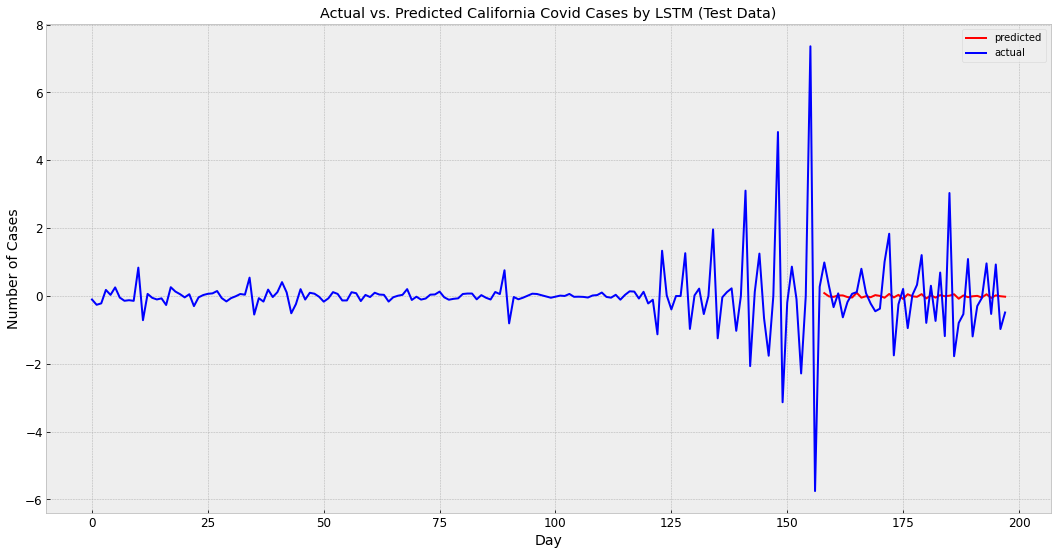

In [83]:
y_pred_CA = model.predict(X_test_CA)
rmseCAlstm = mean_squared_error(y_test_CA, y_pred_CA)**.5
print('RMSE:', rmseCAlstm)
mseCAlstm = mean_absolute_error(y_test_CA, y_pred_CA)
print('MAE:', mseCAlstm)
r2CAlstm = r2_score(y_test_CA, y_pred_CA)
print('r2:', r2CAlstm)

total_CA = np.concatenate((y_train_CA, y_test_CA))
t_CA = range(len(total_CA) - len(y_test_CA), len(total_CA))
print('California New Case LSTM\n')
plt.plot(t_CA, y_pred_CA, color='red')
plt.plot(total_CA, color='blue')
plt.title('Actual vs. Predicted California Covid Cases by LSTM (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])
plt.show()

## Prediction of New Death

In [84]:
diffCA = deathCA.shift(1).dropna()
diffCA = diffCA.diff().dropna()

In [85]:
train_set_CA = diffCA[diffCA.index < '2021-09-15']
test_set_CA = diffCA[diffCA.index > '2021-09-15']

In [86]:
scaler = StandardScaler()

In [87]:
X, y = [], []
time_steps = 45
for i in range(len(train_set_CA) - time_steps):
  x = train_set_CA[i:(i + time_steps)]
  X.append(x)
  y.append(train_set_CA[i + time_steps])

X = scaler.fit_transform(np.array(X))
y = scaler.fit_transform(np.array(y).reshape(-1,1)).reshape(-1,1)

split = int(len(X) * 0.8)
X_train_CA = X[:split]
X_test_CA = X[split:]
y_train_CA = y[:split]
y_test_CA = y[split:]
X_train_CA = np.reshape(X_train_UT, (X_train_CA.shape[0], 1, X_train_CA.shape[1]))
X_test_CA = np.reshape(X_test_CA, (X_test_CA.shape[0], 1, X_test_CA.shape[1]))

### Random Forest

In [88]:
regressor = RandomForestRegressor(n_estimators=100, min_samples_split=7)

In [89]:
regressor.fit(np.squeeze(X_train_CA, axis = 1),y_train_CA)

RandomForestRegressor(min_samples_split=7)

RMSE: 1.2282699809906343
MAE: 0.7433612434620056
r2: -0.12997508930479995
California New Death Random Forest



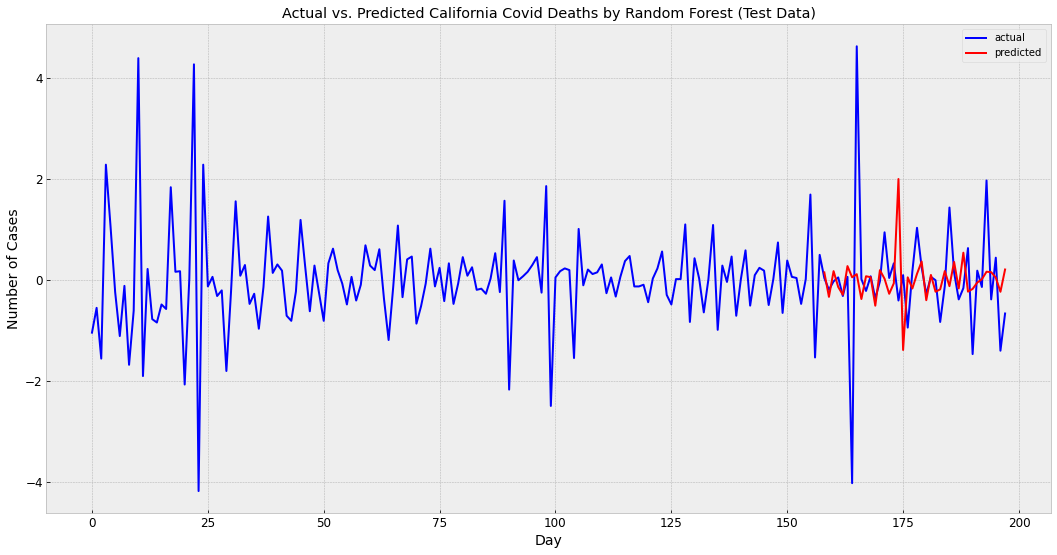

In [90]:
y_pred_CA = regressor.predict(np.squeeze(X_test_CA, axis = 1))
rmseDCArf = mean_squared_error(y_test_CA, y_pred_CA)**.5
print('RMSE:', rmseDCArf)
mseDCArf = mean_absolute_error(y_test_CA, y_pred_CA)
print('MAE:', mseDCArf)
r2DCArf = r2_score(y_test_CA, y_pred_CA)
print('r2:', r2DCArf)

aCA = np.concatenate((y_train_CA, y_test_CA))
print('California New Death Random Forest\n')
plt.plot(aCA, color='blue', label='actual')
plt.plot(range(y_train_CA.shape[0], y_train_CA.shape[0] + y_pred_CA.shape[0]), y_pred_CA, color='red', label='predicted')
plt.title('Actual vs. Predicted California Covid Deaths by Random Forest (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### XGBoost

In [91]:
model = XGBRegressor(n_estimators=20)
model.fit(np.squeeze(X_train_CA, axis=1),y_train_CA)

y_pred_CA = model.predict(np.squeeze(X_test_CA, axis = 1))
rmseDCAxg = mean_squared_error(y_test_CA, y_pred_CA)**.5
print('RMSE:',rmseDCAxg)
mseDCAxg = mean_absolute_error(y_test_CA, y_pred_CA)
print('MAE:', mseDCAxg)
r2DCAxg = r2_score(y_test_CA, y_pred_CA)
print('r2:', r2DCAxg)

[03:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.1726443119251377
MAE: 0.7035567203061062
r2: -0.029944437527755108


California New Death XGBoost



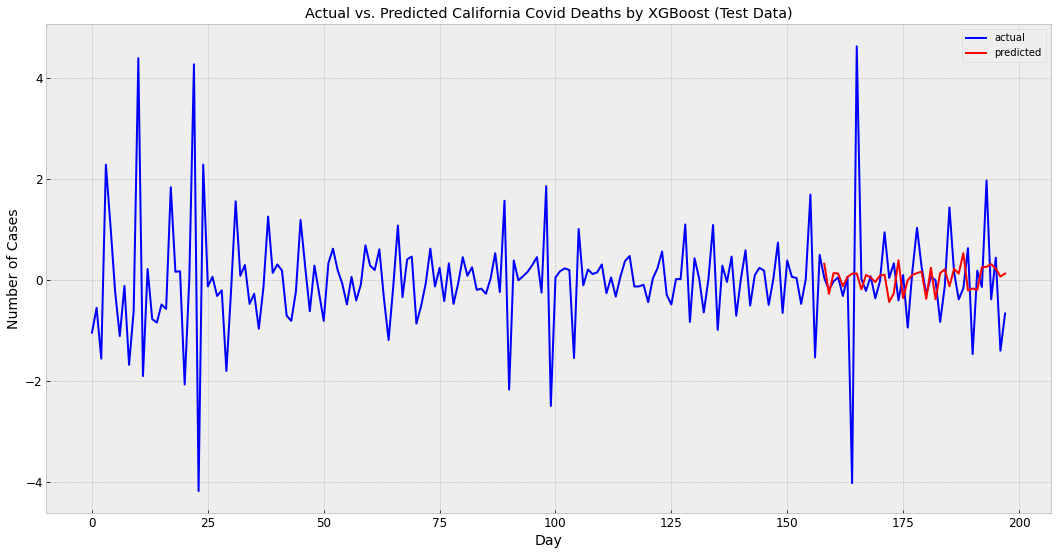

In [92]:
aCA = np.concatenate((y_train_CA, y_test_CA))
print('California New Death XGBoost\n')
plt.plot(aCA, color='blue', label='actual')
plt.plot(range(y_train_CA.shape[0], y_train_CA.shape[0] + y_pred_CA.shape[0]), y_pred_CA, color='red', label='predicted')
plt.title('Actual vs. Predicted California Covid Deaths by XGBoost (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### LSTM

In [93]:
model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(90, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(90))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mean_squared_error'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1, 90)             48960     
                                                                 
 dropout_14 (Dropout)        (None, 1, 90)             0         
                                                                 
 lstm_15 (LSTM)              (None, 1, 48)             26688     
                                                                 
 dropout_15 (Dropout)        (None, 1, 48)             0         
                                                                 
 lstm_16 (LSTM)              (None, 90)                50040     
                                                                 
 dropout_16 (Dropout)        (None, 90)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [94]:
batchsize = 32
epochs =  100
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-10)
history = model.fit(X_train_CA,
                    y_train_CA,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

Epoch 1/100
4/4 [==============================] - 6s 449ms/step - loss: 1.0422 - mean_squared_error: 1.0422 - val_loss: 0.4135 - val_mean_squared_error: 0.4135 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0371 - mean_squared_error: 1.0371 - val_loss: 0.4134 - val_mean_squared_error: 0.4134 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0343 - mean_squared_error: 1.0343 - val_loss: 0.4134 - val_mean_squared_error: 0.4134 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 1.0281 - mean_squared_error: 1.0281 - val_loss: 0.4131 - val_mean_squared_error: 0.4131 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 14ms/step - loss: 1.0216 - mean_squared_error: 1.0216 - val_loss: 0.4127 - val_mean_squared_error: 0.4127 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 1.0103 - mean_squared_error: 1.0103 - val_loss: 0.4120 - val_m

2/2 [==============================] - 1s 7ms/step
RMSE: 1.2125135945810033
MAE: 0.729119127270112
r2: -0.10117014174281702
California New Death LSTM



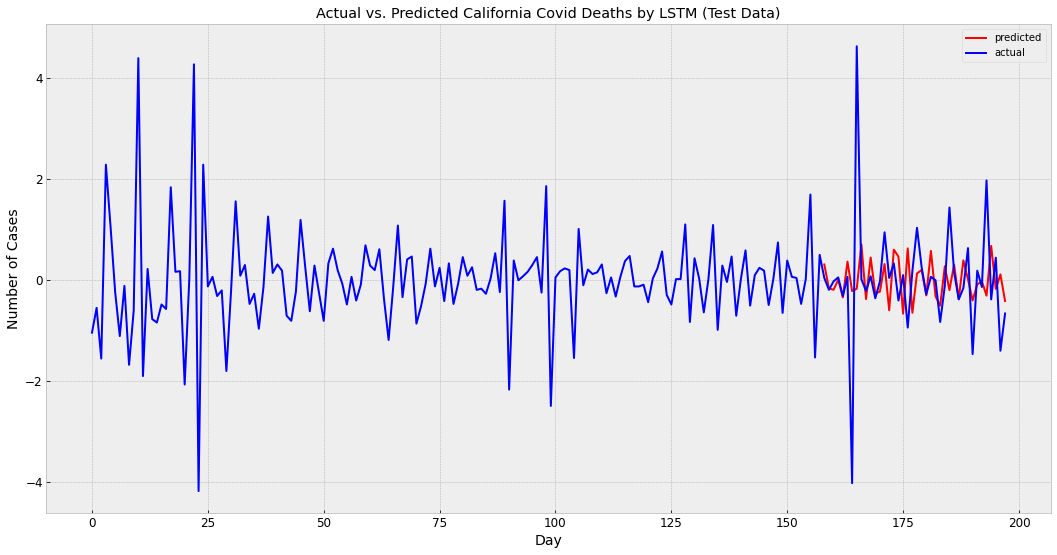

In [95]:
y_pred_CA = model.predict(X_test_CA)
rmseDCAlstm = mean_squared_error(y_test_CA, y_pred_CA)**.5
print('RMSE:', rmseDCAlstm)
mseDCAlstm = mean_absolute_error(y_test_CA, y_pred_CA)
print('MAE:', mseDCAlstm)
r2DCAlstm = r2_score(y_test_CA, y_pred_CA)
print('r2:', r2DCAlstm)

total_CA = np.concatenate((y_train_CA, y_test_CA))
t_CA = range(len(total_CA) - len(y_test_CA), len(total_CA))
print('California New Death LSTM\n')
plt.plot(t_CA, y_pred_CA, color='red')
plt.plot(total_CA, color='blue')
plt.title('Actual vs. Predicted California Covid Deaths by LSTM (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])
plt.show()

## Prediction of Vaccination Data

In [96]:
diffCA = vaccination_CA.shift(1).dropna()
diffCA = diffCA.diff().dropna()

In [97]:
train_set_CA_cv = diffCA[diffCA.index < '2021-09-15']

test_set_CA_cv = diffCA[diffCA.index > '2021-09-15']

X, y = [], []
time_steps = 45
for i in range(len(train_set_CA_cv) - time_steps):
  x = train_set_CA_cv[i:(i+time_steps)]
  X.append(x)
  y.append(train_set_CA_cv[i+time_steps])
X = scaler.fit_transform(np.array(X))
y = scaler.fit_transform(np.array(y).reshape(-1,1)).reshape(-1,1)

split = int(len(X) * 0.8)
X_train_CA_cv = X[:split]
X_test_CA_cv = X[split:]
y_train_CA_cv = y[:split]
y_test_CA_cv = y[split:]
X_train_CA_cv = np.reshape(X_train_CA_cv, (X_train_CA_cv.shape[0], 1, X_train_CA_cv.shape[1]))
X_test_CA_cv = np.reshape(X_test_CA_cv, (X_test_CA_cv.shape[0], 1, X_test_CA_cv.shape[1]))

### Random Forest

In [98]:
regressor = RandomForestRegressor(n_estimators=100, min_samples_split=7)

In [99]:
regressor.fit(np.squeeze(X_train_CA_cv, axis =1 ), y_train_CA_cv)

RandomForestRegressor(min_samples_split=7)

RMSE: 0.2296450475323762
MAE: 0.1604220074854325
RMSE: 0.09908952244038183
California Vaccination Random Forest



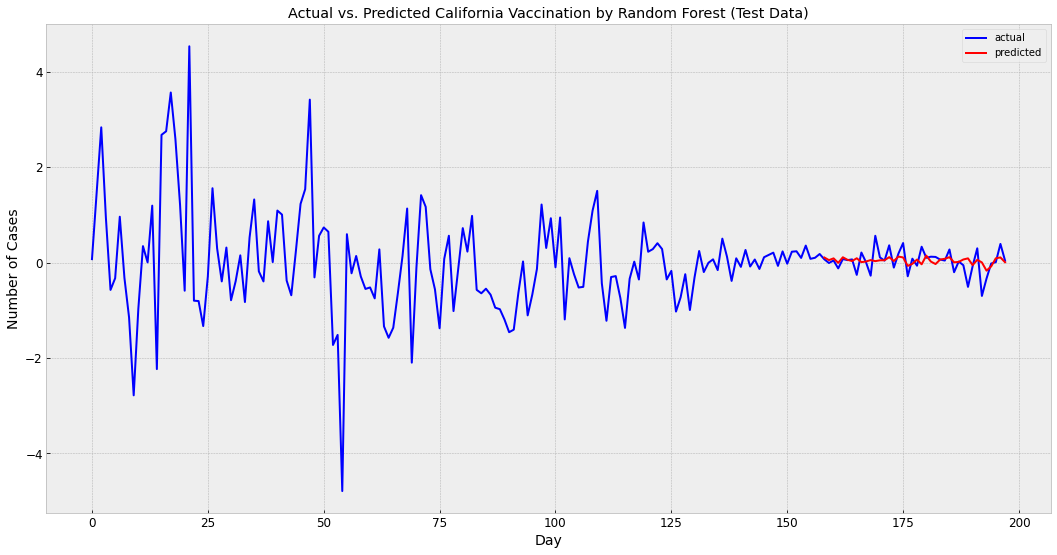

In [100]:
y_pred_CA_cv = regressor.predict(np.squeeze(X_test_CA_cv, axis =1 ))
rmseCAcvRF = mean_squared_error(y_test_CA_cv,y_pred_CA_cv)**.5
print('RMSE:', rmseCAcvRF)
mseCAcvRF = mean_absolute_error(y_test_CA_cv,y_pred_CA_cv)
print('MAE:', mseCAcvRF)
r2CAcvRF = r2_score(y_test_CA_cv,y_pred_CA_cv)
print('RMSE:', r2CAcvRF)

a = np.concatenate((y_train_CA_cv,y_test_CA_cv))
print('California Vaccination Random Forest\n')
plt.plot(a, color='blue', label='actual')
plt.plot(range(y_train_CA_cv.shape[0], y_train_CA_cv.shape[0] + y_pred_CA_cv.shape[0]), y_pred_CA_cv, color='red', label='predicted')
plt.title('Actual vs. Predicted California Vaccination by Random Forest (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### XGBoost

In [101]:
model = XGBRegressor(n_estimators=20)
model.fit(np.squeeze(X_train_CA_cv),y_train_CA_cv)

y_pred_CA_cv = model.predict(np.squeeze(X_test_CA_cv))
rmseCAcvXG = mean_squared_error(y_test_CA_cv,y_pred_CA_cv)**.5
print('RMSE:',rmseCAcvXG)
mseCAcvXG = mean_absolute_error(y_test_CA_cv,y_pred_CA_cv)
print('MAE:', mseCAcvXG)
r2CAcvXG = r2_score(y_test_CA_cv,y_pred_CA_cv)
print('RMSE:', r2CAcvXG)

[03:28:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.2276291297985928
MAE: 0.1628697780843095
RMSE: 0.1148372158961869


California Vaccination XGBoost



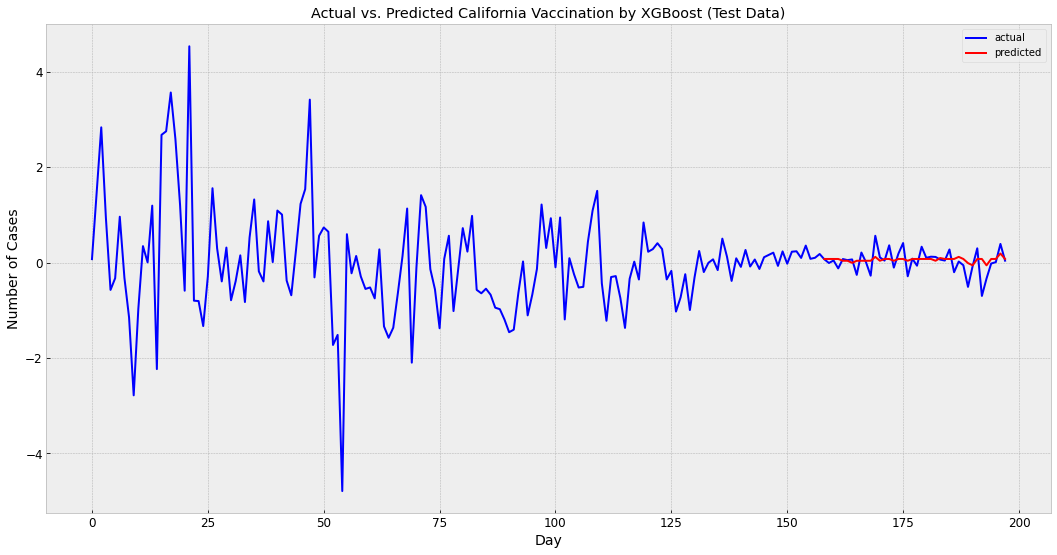

In [102]:
a = np.concatenate((y_train_CA_cv,y_test_CA_cv))
print('California Vaccination XGBoost\n')
plt.plot(np.squeeze(a,axis = 1), color='blue', label='actual')
plt.plot(range(y_train_CA_cv.shape[0], y_train_CA_cv.shape[0] + y_pred_CA_cv.shape[0]), y_pred_CA_cv, color='red', label='predicted')
plt.title('Actual vs. Predicted California Vaccination by XGBoost (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend()
plt.show()

### LSTM

In [103]:
model = Sequential()
model.add(Input(shape=(1, time_steps)))
model.add(LSTM(180, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(90, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(48, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(90))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mean_squared_error'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 1, 180)            162720    
                                                                 
 dropout_17 (Dropout)        (None, 1, 180)            0         
                                                                 
 lstm_18 (LSTM)              (None, 1, 90)             97560     
                                                                 
 dropout_18 (Dropout)        (None, 1, 90)             0         
                                                                 
 lstm_19 (LSTM)              (None, 1, 60)             36240     
                                                                 
 dropout_19 (Dropout)        (None, 1, 60)             0         
                                                                 
 lstm_20 (LSTM)              (None, 1, 48)            

In [104]:
batchsize = 32
epochs =  100
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_squared_error', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-2)
history = model.fit(X_train_CA_cv,
                    y_train_CA_cv,
                    batch_size=batchsize,
                    epochs=epochs,
                    validation_split=0.2,
                    shuffle=False,
                    callbacks=[learning_rate_reduction])

Epoch 1/100
4/4 [==============================] - 11s 788ms/step - loss: 1.5237 - mean_squared_error: 1.5237 - val_loss: 0.1198 - val_mean_squared_error: 0.1198 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 1.5226 - mean_squared_error: 1.5226 - val_loss: 0.1199 - val_mean_squared_error: 0.1199 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 19ms/step - loss: 1.5224 - mean_squared_error: 1.5224 - val_loss: 0.1199 - val_mean_squared_error: 0.1199 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 1.5218 - mean_squared_error: 1.5218 - val_loss: 0.1199 - val_mean_squared_error: 0.1199 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 1.5204 - mean_squared_error: 1.5204 - val_loss: 0.1199 - val_mean_squared_error: 0.1199 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 0s 20ms/step - loss: 1.5178 - mean_squared_error: 1.5178 - val_loss: 0.1199 - val_

2/2 [==============================] - 2s 9ms/step
RMSE: 0.33380054854321717
MAE: 0.254768588407198
RMSE: -0.9034503887201546
California Vaccination LSTM



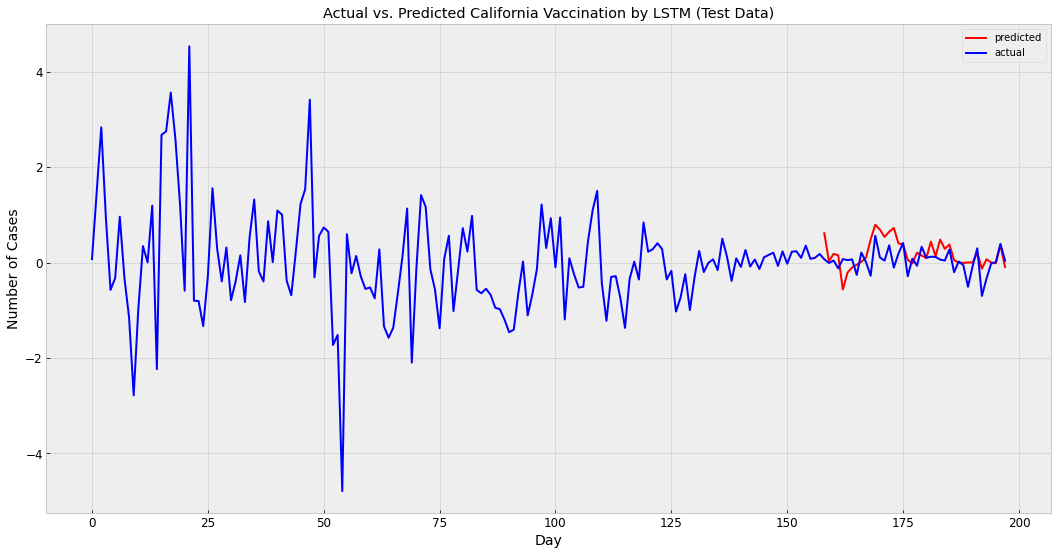

In [105]:
y_pred_CA_cv = model.predict(X_test_CA_cv)
rmseCAcvLSTM = mean_squared_error(y_test_CA_cv,y_pred_CA_cv)**.5
print('RMSE:', rmseCAcvLSTM)
mseCAcvLSTM = mean_absolute_error(y_test_CA_cv,y_pred_CA_cv)
print('MAE:', mseCAcvLSTM)
r2CAcvLSTM = r2_score(y_test_CA_cv,y_pred_CA_cv)
print('RMSE:', r2CAcvLSTM)

total_CA_cv = np.concatenate((y_train_CA_cv,y_test_CA_cv))
t_CA_cv = range(len(total_CA_cv) - len(y_test_CA_cv), len(total_CA_cv))
print('California Vaccination LSTM\n')
plt.plot(t_CA_cv, y_pred_CA_cv, color='red')
plt.plot(total_CA_cv, color='blue')
plt.title('Actual vs. Predicted California Vaccination by LSTM (Test Data)')
plt.ylabel('Number of Cases')
plt.xlabel('Day')
plt.legend(['predicted', 'actual'])
plt.show()

# Result

In [117]:
data = ['Random Forest', 'XGBoost', 'LSTM']
measure_DF_UT = pd.DataFrame(columns=['MAE', 'RMSE', 'R-squared'])
measure_DF_UT.insert(loc=0, column=' ', value=data)

measure_DF_UT.loc[0, 'MAE'] = mseUTrf
measure_DF_UT.loc[0, 'RMSE'] = rmseUTrf
measure_DF_UT.loc[0, 'R-squared'] = r2UTrf

measure_DF_UT.loc[1, 'MAE'] = mseUTxg
measure_DF_UT.loc[1, 'RMSE'] = rmseUTxg
measure_DF_UT.loc[1, 'R-squared'] = r2UTxg

measure_DF_UT.loc[2, 'MAE'] = mseUTlstm
measure_DF_UT.loc[2, 'RMSE'] = rmseUTlstm
measure_DF_UT.loc[2, 'R-squared'] = r2UTlstm

print('Utah New Case\n')
measure_DF_UT

Utah New Case



MAE      RMSE R-squared
0  Random Forest  0.791593  1.202127  0.415881
1        XGBoost  0.829475  1.265033  0.353149
2           LSTM  0.948916  1.276607  0.341259

In [116]:
data = ['Random Forest', 'XGBoost', 'LSTM']
measure_DF_UT = pd.DataFrame(columns=['MAE', 'RMSE', 'R-squared'])
measure_DF_UT.insert(loc=0, column=' ', value=data)

measure_DF_UT.loc[0, 'MAE'] = mseCArf
measure_DF_UT.loc[0, 'RMSE'] = rmseCArf
measure_DF_UT.loc[0, 'R-squared'] = r2CArf

measure_DF_UT.loc[1, 'MAE'] = mseCAxg
measure_DF_UT.loc[1, 'RMSE'] = rmseCAxg
measure_DF_UT.loc[1, 'R-squared'] = r2CAxg

measure_DF_UT.loc[2, 'MAE'] = mseCAlstm
measure_DF_UT.loc[2, 'RMSE'] = rmseCAlstm
measure_DF_UT.loc[2, 'R-squared'] = r2CAlstm

print('California New Case\n')
measure_DF_UT

California New Case



MAE      RMSE R-squared
0  Random Forest  0.822736  1.041273 -0.237912
1        XGBoost  0.849164  1.063978 -0.292486
2           LSTM  0.703095  0.927142  0.018583

In [115]:
data = ['Random Forest', 'XGBoost', 'LSTM']
measure_DF_UT = pd.DataFrame(columns=['MAE', 'RMSE', 'R-squared'])
measure_DF_UT.insert(loc=0, column=' ', value=data)

measure_DF_UT.loc[0, 'MAE'] = mseDUTrf
measure_DF_UT.loc[0, 'RMSE'] = rmseDUTrf
measure_DF_UT.loc[0, 'R-squared'] = r2DUTrf

measure_DF_UT.loc[1, 'MAE'] = mseDUTxg
measure_DF_UT.loc[1, 'RMSE'] = rmseDUTxg
measure_DF_UT.loc[1, 'R-squared'] = r2DUTxg

measure_DF_UT.loc[2, 'MAE'] = mseDUTlstm
measure_DF_UT.loc[2, 'RMSE'] = rmseDUTlstm
measure_DF_UT.loc[2, 'R-squared'] = r2DUTlstm

print('Utah New Death\n')
measure_DF_UT

Utah New Death



MAE      RMSE R-squared
0  Random Forest  0.257996   0.38831  0.055341
1        XGBoost  0.272973  0.396754  0.013811
2           LSTM   0.25952  0.398631  0.004455

In [114]:
data = ['Random Forest', 'XGBoost', 'LSTM']
measure_DF_UT = pd.DataFrame(columns=['MAE', 'RMSE', 'R-squared'])
measure_DF_UT.insert(loc=0, column=' ', value=data)

measure_DF_UT.loc[0, 'MAE'] = mseDCArf
measure_DF_UT.loc[0, 'RMSE'] = rmseDCArf
measure_DF_UT.loc[0, 'R-squared'] = r2DCArf

measure_DF_UT.loc[1, 'MAE'] = mseDCAxg
measure_DF_UT.loc[1, 'RMSE'] = rmseDCAxg
measure_DF_UT.loc[1, 'R-squared'] = r2DCAxg

measure_DF_UT.loc[2, 'MAE'] = mseDCAlstm
measure_DF_UT.loc[2, 'RMSE'] = rmseDCAlstm
measure_DF_UT.loc[2, 'R-squared'] = r2DCAlstm

print('California New Death\n')
measure_DF_UT

California New Death



MAE      RMSE R-squared
0  Random Forest  0.743361   1.22827 -0.129975
1        XGBoost  0.703557  1.172644 -0.029944
2           LSTM  0.729119  1.212514  -0.10117

In [113]:
data = ['Random Forest', 'XGBoost', 'LSTM']
measure_DF_UT = pd.DataFrame(columns=['MAE', 'RMSE', 'R-squared'])
measure_DF_UT.insert(loc=0, column=' ', value=data)

measure_DF_UT.loc[0, 'MAE'] = mseUTcvRF
measure_DF_UT.loc[0, 'RMSE'] = rmseUTcvRF
measure_DF_UT.loc[0, 'R-squared'] = r2UTcvRF

measure_DF_UT.loc[1, 'MAE'] = mseUTcvXG
measure_DF_UT.loc[1, 'RMSE'] = rmseUTcvXG
measure_DF_UT.loc[1, 'R-squared'] = r2UTcvXG

measure_DF_UT.loc[2, 'MAE'] = mseUTcvLSTM
measure_DF_UT.loc[2, 'RMSE'] = rmseUTcvLSTM
measure_DF_UT.loc[2, 'R-squared'] = r2UTcvLSTM

print('Utah Vaccination\n')
measure_DF_UT

Utah Vaccination



MAE      RMSE R-squared
0  Random Forest  0.380361  0.556297  0.193127
1        XGBoost  0.420589  0.557512  0.189598
2           LSTM  0.510786  0.622574 -0.010585

In [112]:
data = ['Random Forest', 'XGBoost', 'LSTM']
measure_DF_UT = pd.DataFrame(columns=['MAE', 'RMSE', 'R-squared'])
measure_DF_UT.insert(loc=0, column=' ', value=data)

measure_DF_UT.loc[0, 'MAE'] = mseCAcvRF
measure_DF_UT.loc[0, 'RMSE'] = rmseCAcvRF
measure_DF_UT.loc[0, 'R-squared'] = r2CAcvRF

measure_DF_UT.loc[1, 'MAE'] = mseCAcvXG
measure_DF_UT.loc[1, 'RMSE'] = rmseCAcvXG
measure_DF_UT.loc[1, 'R-squared'] = r2CAcvXG

measure_DF_UT.loc[2, 'MAE'] = mseCAcvLSTM
measure_DF_UT.loc[2, 'RMSE'] = rmseCAcvLSTM
measure_DF_UT.loc[2, 'R-squared'] = r2CAcvLSTM

print('California Vaccination\n')
measure_DF_UT

California Vaccination



MAE      RMSE R-squared
0  Random Forest  0.160422  0.229645   0.09909
1        XGBoost   0.16287  0.227629  0.114837
2           LSTM  0.254769  0.333801  -0.90345